In [20]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

In [21]:
import os
import logging

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [22]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape
# train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'

((256351, 68), (90067, 67))

In [23]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [24]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()
# train['']


시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [25]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [26]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [27]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [28]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [29]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [30]:
# 5. Binning(구간화) 예시
# 예: 임신 시도 또는 마지막 임신 경과 연수
if '임신 시도 또는 마지막 임신 경과 연수' in train.columns:
    bins = [-0.1, 0.9, 3, 6, 10, 20]  # 0 이하, 1~3, 4~6, 7~10, 11~20
    labels = ['0년 이하','1~3년','4~6년','7~10년','11~20년']
    train['임신시도_bin'] = pd.cut(train['임신 시도 또는 마지막 임신 경과 연수'], bins=bins, labels=labels)
    test['임신시도_bin']  = pd.cut(test['임신 시도 또는 마지막 임신 경과 연수'],  bins=bins, labels=labels)

# 예: 총 생성 배아 수 (0~20, 21이상 구간)
if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=100)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=100)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [31]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [32]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [33]:
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )

KeyError: "['임신 시도 또는 마지막 임신 경과 연수'] not found in axis"

In [34]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
       '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부',
       'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부',
       '임신시도_bin', '총_생성_배아_bin', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [35]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', '총_생성_배아_bin','PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인',"임신시도_bin"] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [36]:
len(categorical_columns) + len(numeric_columns)

59

In [37]:
def make_feature(df):
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)

  df['IVF 시술 성공률'] = df['IVF 임신 횟수'] / (df['IVF 시술 횟수'] + 1)    
  df['DI 시술 성공률'] = df['DI 임신 횟수'] / (df['DI 시술 횟수'] + 1)         
  df['클리닉 시술 비율'] = df['총 시술 횟수'] / (df['클리닉 내 총 시술 횟수'] + 1)  
  df['배아 이용 효율'] = (df['이식된 배아 수'] + df['저장된 배아 수']) / (df['총 생성 배아 수'] + 1) 

  return df

In [38]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 71), (90067, 71))

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 수치형 변수(정수, 실수)를 선택하여 스케일링
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

X.shape, test.shape

((256351, 71), (90067, 71))

In [40]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [41]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [42]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
          "num_iterations": trial.suggest_int("num_iterations", 1500, 3000),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        #  "random_state":  trial.suggest_int('random_state', 42, 42),
        "random_state": seed,
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [43]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 20)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_cpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="cpu" )
    # model_cpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_cpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 40)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    # model_lgbm = lgb.LGBMClassifier(class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((2*test_pred+test_pred_lgbm)/3)

[I 2025-02-24 02:20:31,092] A new study created in memory with name: no-name-b362fff8-79da-4f80-9af3-a4ee28b6e9a6


Seed 4972 Start!
0:	test: 0.7248534	best: 0.7248534 (0)	total: 174ms	remaining: 6m 50s
300:	test: 0.7388549	best: 0.7388549 (300)	total: 38.2s	remaining: 4m 21s
600:	test: 0.7402038	best: 0.7402038 (600)	total: 1m 20s	remaining: 3m 55s
900:	test: 0.7405508	best: 0.7405551 (897)	total: 2m	remaining: 3m 16s
1200:	test: 0.7407102	best: 0.7407442 (1191)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7407861	best: 0.7408169 (1422)	total: 3m 36s	remaining: 2m 4s
1800:	test: 0.7407867	best: 0.7408234 (1535)	total: 4m 27s	remaining: 1m 23s


[I 2025-02-24 02:25:04,603] Trial 0 finished with value: 0.74082339730219 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.74082339730219.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408233973
bestIteration = 1535

Shrink model to first 1536 iterations.
저장 완료
0:	test: 0.6987658	best: 0.6987658 (0)	total: 51.1ms	remaining: 1m 51s


Training has stopped (degenerate solution on iteration 220, probably too small l2-regularization, try to increase it)
[I 2025-02-24 02:25:14,753] Trial 1 finished with value: 0.728344229361763 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.74082339730219.



bestTest = 0.7283442294
bestIteration = 219

Shrink model to first 220 iterations.
0:	test: 0.6987658	best: 0.6987658 (0)	total: 48.5ms	remaining: 2m 2s
300:	test: 0.7404665	best: 0.7404990 (260)	total: 14.7s	remaining: 1m 49s
600:	test: 0.7401413	best: 0.7407239 (354)	total: 30s	remaining: 1m 36s


[I 2025-02-24 02:25:47,664] Trial 2 finished with value: 0.7407239238926291 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.74082339730219.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407239239
bestIteration = 354

Shrink model to first 355 iterations.
0:	test: 0.6987658	best: 0.6987658 (0)	total: 49.5ms	remaining: 1m 55s
300:	test: 0.7392832	best: 0.7392832 (300)	total: 14.2s	remaining: 1m 35s
600:	test: 0.7403467	best: 0.7403467 (600)	total: 29s	remaining: 1m 23s
900:	test: 0.7403462	best: 0.7404103 (649)	total: 43.7s	remaining: 1m 9s


[I 2025-02-24 02:26:33,939] Trial 3 finished with value: 0.7404103197936702 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.74082339730219.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404103198
bestIteration = 649

Shrink model to first 650 iterations.
0:	test: 0.7248037	best: 0.7248037 (0)	total: 98.9ms	remaining: 2m 52s
300:	test: 0.7374568	best: 0.7374568 (300)	total: 36.7s	remaining: 2m 55s
600:	test: 0.7385208	best: 0.7385396 (592)	total: 1m 15s	remaining: 2m 22s
900:	test: 0.7383814	best: 0.7387880 (791)	total: 1m 55s	remaining: 1m 47s


[I 2025-02-24 02:28:56,616] Trial 4 finished with value: 0.7387879566083424 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.74082339730219.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387879566
bestIteration = 791

Shrink model to first 792 iterations.
0:	test: 0.6987658	best: 0.6987658 (0)	total: 46.5ms	remaining: 1m 36s
300:	test: 0.7400415	best: 0.7400415 (300)	total: 14s	remaining: 1m 22s
600:	test: 0.7406126	best: 0.7406982 (544)	total: 28.7s	remaining: 1m 10s


[I 2025-02-24 02:29:37,721] Trial 5 finished with value: 0.7406981700791846 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.74082339730219.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406981701
bestIteration = 544

Shrink model to first 545 iterations.
0:	test: 0.7135536	best: 0.7135536 (0)	total: 53.1ms	remaining: 1m 45s
300:	test: 0.7404517	best: 0.7404517 (300)	total: 17.1s	remaining: 1m 36s
600:	test: 0.7411251	best: 0.7411528 (582)	total: 35.1s	remaining: 1m 21s
900:	test: 0.7411768	best: 0.7412031 (895)	total: 53.4s	remaining: 1m 4s
1200:	test: 0.7411606	best: 0.7412538 (1155)	total: 1m 12s	remaining: 47.9s


[I 2025-02-24 02:31:06,076] Trial 6 finished with value: 0.7412537829933807 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7412537829933807.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741253783
bestIteration = 1155

Shrink model to first 1156 iterations.
저장 완료
0:	test: 0.7232063	best: 0.7232063 (0)	total: 68.7ms	remaining: 2m 12s
300:	test: 0.7386465	best: 0.7393123 (220)	total: 24.4s	remaining: 2m 12s


[I 2025-02-24 02:31:49,326] Trial 7 finished with value: 0.7393123441156733 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7412537829933807.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393123441
bestIteration = 220

Shrink model to first 221 iterations.
0:	test: 0.7205836	best: 0.7205836 (0)	total: 70.6ms	remaining: 2m 14s
300:	test: 0.7404151	best: 0.7404637 (290)	total: 23.2s	remaining: 2m 3s
600:	test: 0.7405258	best: 0.7405788 (567)	total: 48.2s	remaining: 1m 44s
900:	test: 0.7398536	best: 0.7405830 (626)	total: 1m 13s	remaining: 1m 22s


[I 2025-02-24 02:33:05,499] Trial 8 finished with value: 0.7405830402887401 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7412537829933807.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405830403
bestIteration = 626

Shrink model to first 627 iterations.
0:	test: 0.7203614	best: 0.7203614 (0)	total: 61.8ms	remaining: 2m 43s
300:	test: 0.7399930	best: 0.7399930 (300)	total: 19.7s	remaining: 2m 33s
600:	test: 0.7409547	best: 0.7410015 (542)	total: 41s	remaining: 2m 19s
900:	test: 0.7408921	best: 0.7410528 (677)	total: 1m 2s	remaining: 2m 1s


[I 2025-02-24 02:34:14,350] Trial 9 finished with value: 0.7410528031874437 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7412537829933807.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410528032
bestIteration = 677

Shrink model to first 678 iterations.
0:	test: 0.7204650	best: 0.7204650 (0)	total: 62.7ms	remaining: 3m 4s
300:	test: 0.7406310	best: 0.7406633 (280)	total: 21.5s	remaining: 3m 8s
600:	test: 0.7410999	best: 0.7410999 (600)	total: 43.6s	remaining: 2m 49s
900:	test: 0.7410748	best: 0.7411412 (624)	total: 1m 5s	remaining: 2m 29s


[I 2025-02-24 02:35:22,047] Trial 10 finished with value: 0.7411412301725515 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 6 with value: 0.7412537829933807.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411412302
bestIteration = 624

Shrink model to first 625 iterations.
0:	test: 0.7204497	best: 0.7204497 (0)	total: 62.5ms	remaining: 3m 6s
300:	test: 0.7407573	best: 0.7407573 (300)	total: 20.7s	remaining: 3m 4s
600:	test: 0.7412157	best: 0.7412182 (590)	total: 42.4s	remaining: 2m 48s
900:	test: 0.7414120	best: 0.7414460 (864)	total: 1m 4s	remaining: 2m 29s
1200:	test: 0.7415753	best: 0.7416025 (1141)	total: 1m 26s	remaining: 2m 9s
1500:	test: 0.7413791	best: 0.7416463 (1288)	total: 1m 49s	remaining: 1m 48s


[I 2025-02-24 02:37:18,751] Trial 11 finished with value: 0.7416463440119117 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7416463440119117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741646344
bestIteration = 1288

Shrink model to first 1289 iterations.
저장 완료
0:	test: 0.7204650	best: 0.7204650 (0)	total: 65.5ms	remaining: 1m 43s
300:	test: 0.7406332	best: 0.7406332 (300)	total: 20.4s	remaining: 1m 27s
600:	test: 0.7411950	best: 0.7412060 (585)	total: 42.7s	remaining: 1m 10s
900:	test: 0.7414446	best: 0.7414454 (891)	total: 1m 6s	remaining: 50.8s
1200:	test: 0.7414160	best: 0.7415066 (1139)	total: 1m 30s	remaining: 29.1s


[I 2025-02-24 02:39:07,690] Trial 12 finished with value: 0.7415065563149776 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07374100696350389, 'l2_leaf_reg': 87.13438924619796}. Best is trial 11 with value: 0.7416463440119117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415065563
bestIteration = 1139

Shrink model to first 1140 iterations.
0:	test: 0.7236075	best: 0.7236075 (0)	total: 80.3ms	remaining: 3m 58s
300:	test: 0.7408132	best: 0.7408947 (284)	total: 27s	remaining: 3m 59s
600:	test: 0.7405948	best: 0.7409858 (326)	total: 56.3s	remaining: 3m 42s


[I 2025-02-24 02:40:06,713] Trial 13 finished with value: 0.7409857503586376 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.0628933885949758, 'l2_leaf_reg': 6.51790052016232}. Best is trial 11 with value: 0.7416463440119117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409857504
bestIteration = 326

Shrink model to first 327 iterations.
0:	test: 0.7220148	best: 0.7220148 (0)	total: 78ms	remaining: 1m 59s
300:	test: 0.7401019	best: 0.7401020 (299)	total: 25.1s	remaining: 1m 42s
600:	test: 0.7408693	best: 0.7408693 (600)	total: 52.7s	remaining: 1m 21s
900:	test: 0.7410353	best: 0.7410478 (707)	total: 1m 21s	remaining: 57.2s


[I 2025-02-24 02:41:38,891] Trial 14 finished with value: 0.7410478041046306 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.030866060002221384, 'l2_leaf_reg': 11.34882823847059}. Best is trial 11 with value: 0.7416463440119117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410478041
bestIteration = 707

Shrink model to first 708 iterations.
0:	test: 0.7203614	best: 0.7203614 (0)	total: 59.8ms	remaining: 1m 30s
300:	test: 0.7403684	best: 0.7405447 (267)	total: 21.5s	remaining: 1m 26s


[I 2025-02-24 02:42:20,274] Trial 15 finished with value: 0.7405447351641179 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.07999105039206215, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7416463440119117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7405447352
bestIteration = 267

Shrink model to first 268 iterations.
0:	test: 0.7235994	best: 0.7235994 (0)	total: 79.8ms	remaining: 3m 28s
300:	test: 0.7413745	best: 0.7414462 (289)	total: 26.4s	remaining: 3m 22s
600:	test: 0.7406647	best: 0.7415569 (396)	total: 55.7s	remaining: 3m 6s


[I 2025-02-24 02:43:25,649] Trial 16 finished with value: 0.7415568767093319 and parameters: {'iterations': 2611, 'depth': 8, 'learning_rate': 0.061628337192966204, 'l2_leaf_reg': 1.715511331143154}. Best is trial 11 with value: 0.7416463440119117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415568767
bestIteration = 396

Shrink model to first 397 iterations.
0:	test: 0.7255964	best: 0.7255964 (0)	total: 89ms	remaining: 4m 6s
300:	test: 0.7407095	best: 0.7409406 (228)	total: 30.2s	remaining: 4m 7s


[I 2025-02-24 02:44:21,909] Trial 17 finished with value: 0.7409405561087724 and parameters: {'iterations': 2773, 'depth': 9, 'learning_rate': 0.06021875089596924, 'l2_leaf_reg': 0.9548353880375359}. Best is trial 11 with value: 0.7416463440119117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409405561
bestIteration = 228

Shrink model to first 229 iterations.
0:	test: 0.7219920	best: 0.7219920 (0)	total: 78.5ms	remaining: 3m 38s
300:	test: 0.7397138	best: 0.7397138 (300)	total: 25.3s	remaining: 3m 28s
600:	test: 0.7400279	best: 0.7401643 (471)	total: 54.4s	remaining: 3m 17s


[I 2025-02-24 02:45:32,960] Trial 18 finished with value: 0.7401643204476727 and parameters: {'iterations': 2779, 'depth': 8, 'learning_rate': 0.029930249503759977, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 11 with value: 0.7416463440119117.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401643204
bestIteration = 471

Shrink model to first 472 iterations.
0:	test: 0.7205889	best: 0.7205889 (0)	total: 69.6ms	remaining: 2m 53s
300:	test: 0.7406755	best: 0.7408292 (287)	total: 24.1s	remaining: 2m 55s


[I 2025-02-24 02:46:21,442] Trial 19 finished with value: 0.7408291508137042 and parameters: {'iterations': 2496, 'depth': 7, 'learning_rate': 0.086083706324774, 'l2_leaf_reg': 2.276175005448344}. Best is trial 11 with value: 0.7416463440119117.
[I 2025-02-24 02:46:21,446] A new study created in memory with name: no-name-b718b711-322b-4bab-b398-ba4eb6581c57


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408291508
bestIteration = 287

Shrink model to first 288 iterations.


[I 2025-02-24 02:46:44,871] Trial 0 finished with value: 0.7303494968782495 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7303494968782495.
[I 2025-02-24 02:47:02,286] Trial 1 finished with value: 0.7407662949908816 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7407662949908816.
[I 2025-02-24 02:47:22,237] Trial 2 finished with value: 0.7408326410391155 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7416463440119117
LGBM val score : 0.7415101736020648
Ensemble val score : 0.7420553317227365


[I 2025-02-24 03:00:40,893] A new study created in memory with name: no-name-04cb0b51-fda0-47ff-adf7-8820f84e672d


0:	test: 0.7183993	best: 0.7183993 (0)	total: 144ms	remaining: 5m 40s
300:	test: 0.7330589	best: 0.7330589 (300)	total: 40.1s	remaining: 4m 35s
600:	test: 0.7345562	best: 0.7345586 (596)	total: 1m 22s	remaining: 4m 3s
900:	test: 0.7348078	best: 0.7348078 (900)	total: 2m 3s	remaining: 3m 20s
1200:	test: 0.7350907	best: 0.7350907 (1200)	total: 2m 48s	remaining: 2m 43s
1500:	test: 0.7352685	best: 0.7353255 (1403)	total: 3m 37s	remaining: 2m 5s
1800:	test: 0.7353221	best: 0.7353298 (1665)	total: 4m 29s	remaining: 1m 24s


[I 2025-02-24 03:05:39,331] Trial 0 finished with value: 0.735329781116079 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.735329781116079.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353297811
bestIteration = 1665

Shrink model to first 1666 iterations.
저장 완료
0:	test: 0.6914493	best: 0.6914493 (0)	total: 56.3ms	remaining: 2m 3s
300:	test: 0.7238491	best: 0.7238491 (300)	total: 15.7s	remaining: 1m 38s
600:	test: 0.7281028	best: 0.7281028 (600)	total: 30.6s	remaining: 1m 21s
900:	test: 0.7303839	best: 0.7303839 (900)	total: 47.2s	remaining: 1m 7s
1200:	test: 0.7315781	best: 0.7315781 (1200)	total: 1m 3s	remaining: 52.6s
1500:	test: 0.7323901	best: 0.7323901 (1500)	total: 1m 20s	remaining: 37s
1800:	test: 0.7329055	best: 0.7329055 (1800)	total: 1m 36s	remaining: 21.1s
2100:	test: 0.7332778	best: 0.7332778 (2100)	total: 1m 56s	remaining: 5.09s


[I 2025-02-24 03:07:41,322] Trial 1 finished with value: 0.7334325988435355 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.735329781116079.


2192:	test: 0.7334326	best: 0.7334326 (2192)	total: 2m 1s	remaining: 0us

bestTest = 0.7334325988
bestIteration = 2192

0:	test: 0.6914493	best: 0.6914493 (0)	total: 58.3ms	remaining: 2m 27s
300:	test: 0.7344101	best: 0.7344835 (289)	total: 15.5s	remaining: 1m 55s
600:	test: 0.7346064	best: 0.7347478 (533)	total: 31.6s	remaining: 1m 41s


[I 2025-02-24 03:08:25,736] Trial 2 finished with value: 0.7347478460706987 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.735329781116079.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347478461
bestIteration = 533

Shrink model to first 534 iterations.
0:	test: 0.6914493	best: 0.6914493 (0)	total: 59.3ms	remaining: 2m 18s
300:	test: 0.7338022	best: 0.7338022 (300)	total: 15.6s	remaining: 1m 45s
600:	test: 0.7345023	best: 0.7345499 (542)	total: 32.9s	remaining: 1m 34s
900:	test: 0.7347286	best: 0.7347286 (900)	total: 50.6s	remaining: 1m 20s
1200:	test: 0.7345938	best: 0.7348514 (983)	total: 1m 8s	remaining: 1m 4s


[I 2025-02-24 03:09:39,055] Trial 3 finished with value: 0.7348514090321103 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.735329781116079.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.734851409
bestIteration = 983

Shrink model to first 984 iterations.
0:	test: 0.7182199	best: 0.7182199 (0)	total: 151ms	remaining: 4m 22s
300:	test: 0.7325341	best: 0.7325361 (297)	total: 45.6s	remaining: 3m 38s
600:	test: 0.7332134	best: 0.7332280 (590)	total: 1m 34s	remaining: 2m 59s
900:	test: 0.7332558	best: 0.7333220 (783)	total: 2m 26s	remaining: 2m 17s
1200:	test: 0.7333069	best: 0.7335106 (1136)	total: 3m 19s	remaining: 1m 30s


[I 2025-02-24 03:13:42,894] Trial 4 finished with value: 0.7335105907523922 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.735329781116079.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7335105908
bestIteration = 1136

Shrink model to first 1137 iterations.
0:	test: 0.6914493	best: 0.6914493 (0)	total: 63.1ms	remaining: 2m 11s
300:	test: 0.7343599	best: 0.7344043 (275)	total: 16.2s	remaining: 1m 35s
600:	test: 0.7343713	best: 0.7346785 (382)	total: 33.2s	remaining: 1m 21s


[I 2025-02-24 03:14:21,222] Trial 5 finished with value: 0.7346785075744087 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.735329781116079.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346785076
bestIteration = 382

Shrink model to first 383 iterations.
0:	test: 0.6951679	best: 0.6951679 (0)	total: 70.2ms	remaining: 2m 20s
300:	test: 0.7346219	best: 0.7346473 (294)	total: 19.1s	remaining: 1m 47s
600:	test: 0.7351458	best: 0.7351601 (587)	total: 38.9s	remaining: 1m 30s
900:	test: 0.7351722	best: 0.7352504 (754)	total: 58.9s	remaining: 1m 11s


[I 2025-02-24 03:15:30,303] Trial 6 finished with value: 0.7352503754326131 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.735329781116079.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352503754
bestIteration = 754

Shrink model to first 755 iterations.
0:	test: 0.7138703	best: 0.7138703 (0)	total: 86.5ms	remaining: 2m 46s
300:	test: 0.7345378	best: 0.7351100 (176)	total: 27s	remaining: 2m 25s


[I 2025-02-24 03:16:13,341] Trial 7 finished with value: 0.7351100106473113 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.735329781116079.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351100106
bestIteration = 176

Shrink model to first 177 iterations.
0:	test: 0.7138966	best: 0.7138966 (0)	total: 87.2ms	remaining: 2m 45s
300:	test: 0.7348233	best: 0.7348233 (300)	total: 25.2s	remaining: 2m 14s
600:	test: 0.7348026	best: 0.7350129 (488)	total: 53.3s	remaining: 1m 55s


[I 2025-02-24 03:17:23,945] Trial 8 finished with value: 0.7350128533556886 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.735329781116079.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350128534
bestIteration = 488

Shrink model to first 489 iterations.
0:	test: 0.7119711	best: 0.7119711 (0)	total: 81.4ms	remaining: 3m 34s
300:	test: 0.7343974	best: 0.7343974 (300)	total: 21.9s	remaining: 2m 49s
600:	test: 0.7355406	best: 0.7355406 (600)	total: 45.6s	remaining: 2m 34s
900:	test: 0.7354303	best: 0.7355425 (603)	total: 1m 9s	remaining: 2m 14s


[I 2025-02-24 03:18:33,914] Trial 9 finished with value: 0.7355424509415842 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7355424509415842.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355424509
bestIteration = 603

Shrink model to first 604 iterations.
저장 완료
0:	test: 0.7119544	best: 0.7119544 (0)	total: 78.4ms	remaining: 3m 50s
300:	test: 0.7340379	best: 0.7340379 (300)	total: 22.4s	remaining: 3m 16s
600:	test: 0.7350752	best: 0.7350897 (597)	total: 45.6s	remaining: 2m 57s
900:	test: 0.7351290	best: 0.7352542 (819)	total: 1m 10s	remaining: 2m 39s


[I 2025-02-24 03:20:01,687] Trial 10 finished with value: 0.7352542474276809 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7355424509415842.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352542474
bestIteration = 819

Shrink model to first 820 iterations.
0:	test: 0.7183355	best: 0.7183355 (0)	total: 138ms	remaining: 6m 11s
300:	test: 0.7340496	best: 0.7340551 (292)	total: 39.8s	remaining: 5m 16s
600:	test: 0.7343697	best: 0.7344681 (471)	total: 1m 26s	remaining: 5m


[I 2025-02-24 03:21:57,385] Trial 11 finished with value: 0.7344681410895593 and parameters: {'iterations': 2693, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 5.267219442277925}. Best is trial 9 with value: 0.7355424509415842.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344681411
bestIteration = 471

Shrink model to first 472 iterations.
0:	test: 0.7140989	best: 0.7140989 (0)	total: 119ms	remaining: 4m 56s
300:	test: 0.7343368	best: 0.7343368 (300)	total: 34.2s	remaining: 4m 8s
600:	test: 0.7347018	best: 0.7347947 (492)	total: 1m 10s	remaining: 3m 40s
900:	test: 0.7345318	best: 0.7348010 (659)	total: 1m 48s	remaining: 3m 11s


[I 2025-02-24 03:23:53,893] Trial 12 finished with value: 0.7348010413260138 and parameters: {'iterations': 2488, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 0.7529394868393271}. Best is trial 9 with value: 0.7355424509415842.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7348010413
bestIteration = 659

Shrink model to first 660 iterations.
0:	test: 0.7121973	best: 0.7121973 (0)	total: 112ms	remaining: 5m 11s
300:	test: 0.7344475	best: 0.7344475 (300)	total: 29.5s	remaining: 4m 4s
600:	test: 0.7351424	best: 0.7351576 (573)	total: 59.9s	remaining: 3m 38s
900:	test: 0.7352685	best: 0.7352929 (873)	total: 1m 30s	remaining: 3m 10s
1200:	test: 0.7352280	best: 0.7353370 (1045)	total: 2m 2s	remaining: 2m 42s


[I 2025-02-24 03:26:12,323] Trial 13 finished with value: 0.7353370167827595 and parameters: {'iterations': 2793, 'depth': 8, 'learning_rate': 0.03929405842707977, 'l2_leaf_reg': 55.074044317639256}. Best is trial 9 with value: 0.7355424509415842.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353370168
bestIteration = 1045

Shrink model to first 1046 iterations.
0:	test: 0.7121942	best: 0.7121942 (0)	total: 108ms	remaining: 5m 17s
300:	test: 0.7350515	best: 0.7350515 (299)	total: 30.4s	remaining: 4m 27s
600:	test: 0.7351826	best: 0.7352742 (526)	total: 1m 2s	remaining: 4m 4s


[I 2025-02-24 03:27:38,016] Trial 14 finished with value: 0.7352742150083993 and parameters: {'iterations': 2950, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 92.74223128282539}. Best is trial 9 with value: 0.7355424509415842.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735274215
bestIteration = 526

Shrink model to first 527 iterations.
0:	test: 0.7140991	best: 0.7140991 (0)	total: 133ms	remaining: 6m 4s
300:	test: 0.7350570	best: 0.7350570 (300)	total: 28.5s	remaining: 3m 52s
600:	test: 0.7352183	best: 0.7353722 (495)	total: 59.7s	remaining: 3m 33s


[I 2025-02-24 03:28:58,363] Trial 15 finished with value: 0.7353722261245754 and parameters: {'iterations': 2752, 'depth': 8, 'learning_rate': 0.042092255830209285, 'l2_leaf_reg': 0.19321110261014834}. Best is trial 9 with value: 0.7355424509415842.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353722261
bestIteration = 495

Shrink model to first 496 iterations.
0:	test: 0.7119711	best: 0.7119711 (0)	total: 78.6ms	remaining: 3m 31s
300:	test: 0.7350715	best: 0.7351037 (275)	total: 22.2s	remaining: 2m 56s
600:	test: 0.7345571	best: 0.7351738 (407)	total: 45.3s	remaining: 2m 37s


[I 2025-02-24 03:29:52,094] Trial 16 finished with value: 0.7351737536143188 and parameters: {'iterations': 2686, 'depth': 6, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 0.24482193011638945}. Best is trial 9 with value: 0.7355424509415842.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351737536
bestIteration = 407

Shrink model to first 408 iterations.
0:	test: 0.7140581	best: 0.7140581 (0)	total: 95.1ms	remaining: 4m 1s
300:	test: 0.7347637	best: 0.7348060 (295)	total: 28.3s	remaining: 3m 31s
600:	test: 0.7340972	best: 0.7350736 (367)	total: 1m	remaining: 3m 14s


[I 2025-02-24 03:30:59,393] Trial 17 finished with value: 0.7350736099223976 and parameters: {'iterations': 2545, 'depth': 8, 'learning_rate': 0.041434586487440916, 'l2_leaf_reg': 0.00795480840919648}. Best is trial 9 with value: 0.7355424509415842.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350736099
bestIteration = 367

Shrink model to first 368 iterations.
0:	test: 0.7119498	best: 0.7119498 (0)	total: 94ms	remaining: 2m 28s
300:	test: 0.7329235	best: 0.7329235 (300)	total: 20.2s	remaining: 1m 26s
600:	test: 0.7344990	best: 0.7344990 (600)	total: 41.7s	remaining: 1m 8s
900:	test: 0.7353033	best: 0.7353531 (867)	total: 1m 4s	remaining: 48.8s
1200:	test: 0.7354802	best: 0.7355502 (1070)	total: 1m 27s	remaining: 28s
1500:	test: 0.7354768	best: 0.7355615 (1284)	total: 1m 50s	remaining: 6.16s


[I 2025-02-24 03:32:56,025] Trial 18 finished with value: 0.7355615368988104 and parameters: {'iterations': 1585, 'depth': 6, 'learning_rate': 0.01958373252715346, 'l2_leaf_reg': 0.01734944121649843}. Best is trial 18 with value: 0.7355615368988104.


1584:	test: 0.7354797	best: 0.7355615 (1284)	total: 1m 56s	remaining: 0us

bestTest = 0.7355615369
bestIteration = 1284

Shrink model to first 1285 iterations.
저장 완료
0:	test: 0.7119497	best: 0.7119497 (0)	total: 79.5ms	remaining: 2m 6s
300:	test: 0.7328687	best: 0.7328687 (300)	total: 19.8s	remaining: 1m 25s
600:	test: 0.7343829	best: 0.7343919 (594)	total: 40.8s	remaining: 1m 7s
900:	test: 0.7349796	best: 0.7349931 (897)	total: 1m 3s	remaining: 48.8s
1200:	test: 0.7349248	best: 0.7350418 (983)	total: 1m 26s	remaining: 28.2s


[I 2025-02-24 03:34:28,928] Trial 19 finished with value: 0.7350418119075182 and parameters: {'iterations': 1595, 'depth': 6, 'learning_rate': 0.019635316366982188, 'l2_leaf_reg': 0.020642063554878846}. Best is trial 18 with value: 0.7355615368988104.
[I 2025-02-24 03:34:28,933] A new study created in memory with name: no-name-37354bac-f0e7-4a75-a8fc-743e2212ebca


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350418119
bestIteration = 983

Shrink model to first 984 iterations.


[I 2025-02-24 03:34:53,022] Trial 0 finished with value: 0.7246138620155663 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7246138620155663.
[I 2025-02-24 03:35:10,202] Trial 1 finished with value: 0.7349083928856764 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7349083928856764.
[I 2025-02-24 03:35:30,230] Trial 2 finished with value: 0.73489316303841 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7355615368988104
LGBM val score : 0.735136800881903
Ensemble val score : 0.7357865613670393


[I 2025-02-24 03:48:07,539] A new study created in memory with name: no-name-6288cdbb-0196-4ba1-9e23-bc30175898d1


0:	test: 0.7268883	best: 0.7268883 (0)	total: 156ms	remaining: 6m 9s
300:	test: 0.7400330	best: 0.7400330 (300)	total: 41.1s	remaining: 4m 42s
600:	test: 0.7416386	best: 0.7416389 (598)	total: 1m 25s	remaining: 4m 9s
900:	test: 0.7422729	best: 0.7422748 (894)	total: 2m 7s	remaining: 3m 26s
1200:	test: 0.7425285	best: 0.7425397 (1186)	total: 2m 51s	remaining: 2m 46s
1500:	test: 0.7426616	best: 0.7426625 (1486)	total: 3m 40s	remaining: 2m 7s
1800:	test: 0.7425676	best: 0.7426763 (1509)	total: 4m 32s	remaining: 1m 25s


[I 2025-02-24 03:52:41,930] Trial 0 finished with value: 0.7426762742235387 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7426762742235387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426762742
bestIteration = 1509

Shrink model to first 1510 iterations.
저장 완료
0:	test: 0.7010484	best: 0.7010484 (0)	total: 59.1ms	remaining: 2m 9s
300:	test: 0.7295478	best: 0.7295478 (300)	total: 13.6s	remaining: 1m 25s


Training has stopped (degenerate solution on iteration 412, probably too small l2-regularization, try to increase it)
[I 2025-02-24 03:53:00,686] Trial 1 finished with value: 0.7319391485038858 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7426762742235387.



bestTest = 0.7319391485
bestIteration = 411

Shrink model to first 412 iterations.
0:	test: 0.7010484	best: 0.7010484 (0)	total: 58.8ms	remaining: 2m 29s
300:	test: 0.7416046	best: 0.7416186 (295)	total: 14.6s	remaining: 1m 48s
600:	test: 0.7414909	best: 0.7418384 (377)	total: 29.8s	remaining: 1m 35s


[I 2025-02-24 03:53:34,629] Trial 2 finished with value: 0.7418383586057724 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7426762742235387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418383586
bestIteration = 377

Shrink model to first 378 iterations.
0:	test: 0.7010484	best: 0.7010484 (0)	total: 52.2ms	remaining: 2m 1s
300:	test: 0.7405382	best: 0.7405382 (300)	total: 13.8s	remaining: 1m 33s
600:	test: 0.7412925	best: 0.7413406 (566)	total: 29s	remaining: 1m 23s
900:	test: 0.7414228	best: 0.7414676 (875)	total: 44.2s	remaining: 1m 10s


[I 2025-02-24 03:54:33,541] Trial 3 finished with value: 0.7414676438697947 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7426762742235387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414676439
bestIteration = 875

Shrink model to first 876 iterations.
0:	test: 0.7269335	best: 0.7269335 (0)	total: 139ms	remaining: 4m 1s
300:	test: 0.7392679	best: 0.7392718 (299)	total: 38.6s	remaining: 3m 4s
600:	test: 0.7405633	best: 0.7405633 (600)	total: 1m 21s	remaining: 2m 34s
900:	test: 0.7406281	best: 0.7407402 (879)	total: 2m 4s	remaining: 1m 56s


[I 2025-02-24 03:57:18,786] Trial 4 finished with value: 0.7407402091779611 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7426762742235387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407402092
bestIteration = 879

Shrink model to first 880 iterations.
0:	test: 0.7010484	best: 0.7010484 (0)	total: 61.4ms	remaining: 2m 7s
300:	test: 0.7410875	best: 0.7411012 (293)	total: 14.5s	remaining: 1m 25s
600:	test: 0.7416592	best: 0.7417743 (584)	total: 29.8s	remaining: 1m 13s


[I 2025-02-24 03:58:03,057] Trial 5 finished with value: 0.7417743098504365 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7426762742235387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417743099
bestIteration = 584

Shrink model to first 585 iterations.
0:	test: 0.7047188	best: 0.7047188 (0)	total: 66.3ms	remaining: 2m 12s
300:	test: 0.7421497	best: 0.7421497 (300)	total: 18s	remaining: 1m 41s
600:	test: 0.7426092	best: 0.7426387 (588)	total: 36.9s	remaining: 1m 25s


[I 2025-02-24 03:58:58,721] Trial 6 finished with value: 0.7426386741729732 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7426762742235387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426386742
bestIteration = 588

Shrink model to first 589 iterations.
0:	test: 0.7221493	best: 0.7221493 (0)	total: 153ms	remaining: 4m 55s
300:	test: 0.7410558	best: 0.7418586 (155)	total: 25.2s	remaining: 2m 16s


[I 2025-02-24 03:59:37,929] Trial 7 finished with value: 0.7418585724056644 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7426762742235387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418585724
bestIteration = 155

Shrink model to first 156 iterations.
0:	test: 0.7221481	best: 0.7221481 (0)	total: 85.5ms	remaining: 2m 42s
300:	test: 0.7419082	best: 0.7419479 (283)	total: 24.6s	remaining: 2m 10s
600:	test: 0.7418197	best: 0.7421025 (406)	total: 51.2s	remaining: 1m 50s


[I 2025-02-24 04:00:39,068] Trial 8 finished with value: 0.742102472353439 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7426762742235387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421024724
bestIteration = 406

Shrink model to first 407 iterations.
0:	test: 0.7209999	best: 0.7209999 (0)	total: 75ms	remaining: 3m 17s
300:	test: 0.7412837	best: 0.7412837 (300)	total: 21.2s	remaining: 2m 44s
600:	test: 0.7422199	best: 0.7422256 (584)	total: 45.5s	remaining: 2m 34s
900:	test: 0.7421946	best: 0.7423030 (680)	total: 1m 9s	remaining: 2m 13s


[I 2025-02-24 04:01:55,190] Trial 9 finished with value: 0.7423029821287929 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7426762742235387.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423029821
bestIteration = 680

Shrink model to first 681 iterations.
0:	test: 0.7258122	best: 0.7258122 (0)	total: 143ms	remaining: 7m 2s
300:	test: 0.7419191	best: 0.7419215 (298)	total: 41.4s	remaining: 6m 3s
600:	test: 0.7427010	best: 0.7427017 (599)	total: 1m 26s	remaining: 5m 35s
900:	test: 0.7426967	best: 0.7427943 (756)	total: 2m 23s	remaining: 5m 26s


[I 2025-02-24 04:04:50,317] Trial 10 finished with value: 0.7427943442598042 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7427943442598042.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427943443
bestIteration = 756

Shrink model to first 757 iterations.
저장 완료
0:	test: 0.7258745	best: 0.7258745 (0)	total: 146ms	remaining: 7m 17s
300:	test: 0.7418691	best: 0.7418691 (300)	total: 44.3s	remaining: 6m 36s
600:	test: 0.7426617	best: 0.7426677 (597)	total: 1m 33s	remaining: 6m 10s
900:	test: 0.7428996	best: 0.7429009 (898)	total: 2m 31s	remaining: 5m 52s
1200:	test: 0.7430029	best: 0.7430086 (1181)	total: 3m 33s	remaining: 5m 18s


[I 2025-02-24 04:09:18,341] Trial 11 finished with value: 0.7430085906822754 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7430085906822754.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430085907
bestIteration = 1181

Shrink model to first 1182 iterations.
저장 완료
0:	test: 0.7213636	best: 0.7213636 (0)	total: 122ms	remaining: 5m 52s
300:	test: 0.7416698	best: 0.7416698 (300)	total: 32.2s	remaining: 4m 37s
600:	test: 0.7425606	best: 0.7425606 (600)	total: 1m 4s	remaining: 4m 4s
900:	test: 0.7428051	best: 0.7428144 (886)	total: 1m 40s	remaining: 3m 42s
1200:	test: 0.7428812	best: 0.7429115 (1153)	total: 2m 15s	remaining: 3m 11s
1500:	test: 0.7428820	best: 0.7429559 (1391)	total: 2m 51s	remaining: 2m 39s


[I 2025-02-24 04:12:33,758] Trial 12 finished with value: 0.7429559275780772 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 11 with value: 0.7430085906822754.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429559276
bestIteration = 1391

Shrink model to first 1392 iterations.
0:	test: 0.7226836	best: 0.7226836 (0)	total: 131ms	remaining: 6m 30s
300:	test: 0.7422529	best: 0.7422529 (300)	total: 31.1s	remaining: 4m 35s
600:	test: 0.7431519	best: 0.7432258 (567)	total: 1m 5s	remaining: 4m 18s


[I 2025-02-24 04:14:11,574] Trial 13 finished with value: 0.74322580364866 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.02991325011301619, 'l2_leaf_reg': 6.51790052016232}. Best is trial 13 with value: 0.74322580364866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432258036
bestIteration = 567

Shrink model to first 568 iterations.
저장 완료
0:	test: 0.7221392	best: 0.7221392 (0)	total: 102ms	remaining: 4m 40s
300:	test: 0.7415489	best: 0.7415489 (300)	total: 30.7s	remaining: 4m 10s
600:	test: 0.7426064	best: 0.7426151 (578)	total: 1m 1s	remaining: 3m 40s
900:	test: 0.7425240	best: 0.7426604 (748)	total: 1m 33s	remaining: 3m 12s


[I 2025-02-24 04:16:01,630] Trial 14 finished with value: 0.7426604486847234 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.030373980283948276, 'l2_leaf_reg': 7.23581953055629}. Best is trial 13 with value: 0.74322580364866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426604487
bestIteration = 748

Shrink model to first 749 iterations.
0:	test: 0.7226733	best: 0.7226733 (0)	total: 117ms	remaining: 2m 56s
300:	test: 0.7420284	best: 0.7422624 (265)	total: 33.6s	remaining: 2m 15s


[I 2025-02-24 04:17:08,038] Trial 15 finished with value: 0.742262387735375 and parameters: {'iterations': 1513, 'depth': 9, 'learning_rate': 0.06272738732962457, 'l2_leaf_reg': 8.66034203066278}. Best is trial 13 with value: 0.74322580364866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422623877
bestIteration = 265

Shrink model to first 266 iterations.
0:	test: 0.7226853	best: 0.7226853 (0)	total: 118ms	remaining: 5m 48s
300:	test: 0.7417559	best: 0.7419015 (270)	total: 31.6s	remaining: 4m 40s


[I 2025-02-24 04:18:11,581] Trial 16 finished with value: 0.741901466168461 and parameters: {'iterations': 2965, 'depth': 9, 'learning_rate': 0.03797914335914334, 'l2_leaf_reg': 0.03562900678874207}. Best is trial 13 with value: 0.74322580364866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419014662
bestIteration = 270

Shrink model to first 271 iterations.
0:	test: 0.7221412	best: 0.7221412 (0)	total: 96.2ms	remaining: 4m 23s
300:	test: 0.7407487	best: 0.7407532 (299)	total: 27.5s	remaining: 3m 42s
600:	test: 0.7421356	best: 0.7421816 (592)	total: 55s	remaining: 3m 15s
900:	test: 0.7425431	best: 0.7425501 (897)	total: 1m 25s	remaining: 2m 55s
1200:	test: 0.7426487	best: 0.7427254 (1161)	total: 1m 57s	remaining: 2m 30s


[I 2025-02-24 04:20:36,805] Trial 17 finished with value: 0.7427254108337675 and parameters: {'iterations': 2739, 'depth': 8, 'learning_rate': 0.020808766182702852, 'l2_leaf_reg': 1.0786964460598871}. Best is trial 13 with value: 0.74322580364866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427254108
bestIteration = 1161

Shrink model to first 1162 iterations.
0:	test: 0.7221373	best: 0.7221373 (0)	total: 97.2ms	remaining: 4m 5s
300:	test: 0.7426648	best: 0.7427060 (291)	total: 27.8s	remaining: 3m 25s
600:	test: 0.7424461	best: 0.7427672 (400)	total: 58.3s	remaining: 3m 6s


[I 2025-02-24 04:21:45,679] Trial 18 finished with value: 0.7427671727826213 and parameters: {'iterations': 2524, 'depth': 8, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 17.72045110479989}. Best is trial 13 with value: 0.74322580364866.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427671728
bestIteration = 400

Shrink model to first 401 iterations.
0:	test: 0.7226811	best: 0.7226811 (0)	total: 121ms	remaining: 5m 40s
300:	test: 0.7420472	best: 0.7420558 (273)	total: 32.2s	remaining: 4m 27s
600:	test: 0.7420553	best: 0.7424167 (370)	total: 1m 7s	remaining: 4m 8s


[I 2025-02-24 04:23:01,980] Trial 19 finished with value: 0.7424166917029206 and parameters: {'iterations': 2809, 'depth': 9, 'learning_rate': 0.03689499993250822, 'l2_leaf_reg': 1.542996333897484}. Best is trial 13 with value: 0.74322580364866.
[I 2025-02-24 04:23:01,984] A new study created in memory with name: no-name-f464877b-7967-4225-af4f-25b8fa12ed75


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424166917
bestIteration = 370

Shrink model to first 371 iterations.


[I 2025-02-24 04:23:25,918] Trial 0 finished with value: 0.7331653398444908 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7331653398444908.
[I 2025-02-24 04:23:43,557] Trial 1 finished with value: 0.742477754057958 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.742477754057958.
[I 2025-02-24 04:24:03,669] Trial 2 finished with value: 0.7421349335715761 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.74322580364866
LGBM val score : 0.7428865255413553
Ensemble val score : 0.7433731499389146


[I 2025-02-24 04:37:32,339] A new study created in memory with name: no-name-a54ef64a-4123-4a95-b596-32625469a1f6


0:	test: 0.7251998	best: 0.7251998 (0)	total: 159ms	remaining: 6m 16s
300:	test: 0.7392610	best: 0.7392610 (300)	total: 42.9s	remaining: 4m 54s
600:	test: 0.7407155	best: 0.7407155 (600)	total: 1m 28s	remaining: 4m 20s
900:	test: 0.7412010	best: 0.7412010 (900)	total: 2m 16s	remaining: 3m 41s
1200:	test: 0.7414293	best: 0.7414420 (1161)	total: 3m 7s	remaining: 3m 2s
1500:	test: 0.7415234	best: 0.7415450 (1386)	total: 4m 4s	remaining: 2m 20s


[I 2025-02-24 04:42:11,859] Trial 0 finished with value: 0.7415449627100428 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7415449627100428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415449627
bestIteration = 1386

Shrink model to first 1387 iterations.
저장 완료
0:	test: 0.7024867	best: 0.7024867 (0)	total: 66.4ms	remaining: 2m 25s


Training has stopped (degenerate solution on iteration 244, probably too small l2-regularization, try to increase it)
[I 2025-02-24 04:42:23,730] Trial 1 finished with value: 0.7281759656297878 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7415449627100428.



bestTest = 0.7281759656
bestIteration = 241

Shrink model to first 242 iterations.
0:	test: 0.7024867	best: 0.7024867 (0)	total: 67.4ms	remaining: 2m 50s
300:	test: 0.7398962	best: 0.7400303 (260)	total: 15.8s	remaining: 1m 56s


[I 2025-02-24 04:42:53,489] Trial 2 finished with value: 0.7400303475773893 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7415449627100428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400303476
bestIteration = 260

Shrink model to first 261 iterations.
0:	test: 0.7024867	best: 0.7024867 (0)	total: 58.4ms	remaining: 2m 16s
300:	test: 0.7392421	best: 0.7392421 (300)	total: 15.3s	remaining: 1m 43s
600:	test: 0.7401762	best: 0.7402049 (596)	total: 31.6s	remaining: 1m 31s
900:	test: 0.7401991	best: 0.7402313 (861)	total: 48s	remaining: 1m 16s
1200:	test: 0.7399663	best: 0.7402777 (971)	total: 1m 4s	remaining: 1m


[I 2025-02-24 04:44:02,103] Trial 3 finished with value: 0.7402777258474101 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7415449627100428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402777258
bestIteration = 971

Shrink model to first 972 iterations.
0:	test: 0.7251469	best: 0.7251469 (0)	total: 146ms	remaining: 4m 14s
300:	test: 0.7383092	best: 0.7383263 (297)	total: 42s	remaining: 3m 21s
600:	test: 0.7394655	best: 0.7394986 (551)	total: 1m 24s	remaining: 2m 40s
900:	test: 0.7396474	best: 0.7396706 (897)	total: 2m 6s	remaining: 1m 58s
1200:	test: 0.7394557	best: 0.7398967 (1126)	total: 2m 54s	remaining: 1m 18s


[I 2025-02-24 04:47:35,311] Trial 4 finished with value: 0.7398966954888413 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7415449627100428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7398966955
bestIteration = 1126

Shrink model to first 1127 iterations.
0:	test: 0.7024867	best: 0.7024867 (0)	total: 56.7ms	remaining: 1m 58s
300:	test: 0.7400670	best: 0.7400802 (288)	total: 15.7s	remaining: 1m 33s
600:	test: 0.7403324	best: 0.7404282 (563)	total: 32s	remaining: 1m 18s


[I 2025-02-24 04:48:21,722] Trial 5 finished with value: 0.7404281827264607 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7415449627100428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404281827
bestIteration = 563

Shrink model to first 564 iterations.
0:	test: 0.7068701	best: 0.7068701 (0)	total: 64.9ms	remaining: 2m 9s
300:	test: 0.7407947	best: 0.7407947 (300)	total: 19.4s	remaining: 1m 49s
600:	test: 0.7413382	best: 0.7413682 (550)	total: 38.5s	remaining: 1m 29s


[I 2025-02-24 04:49:16,473] Trial 6 finished with value: 0.7413682344477303 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7415449627100428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413682344
bestIteration = 550

Shrink model to first 551 iterations.
0:	test: 0.7219954	best: 0.7219954 (0)	total: 130ms	remaining: 4m 10s
300:	test: 0.7396412	best: 0.7402488 (146)	total: 27s	remaining: 2m 25s


[I 2025-02-24 04:49:57,196] Trial 7 finished with value: 0.7402488416210123 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7415449627100428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7402488416
bestIteration = 146

Shrink model to first 147 iterations.
0:	test: 0.7219976	best: 0.7219976 (0)	total: 93.1ms	remaining: 2m 57s
300:	test: 0.7407089	best: 0.7407298 (297)	total: 26s	remaining: 2m 18s
600:	test: 0.7407012	best: 0.7410197 (387)	total: 54.3s	remaining: 1m 57s


[I 2025-02-24 04:50:59,865] Trial 8 finished with value: 0.7410197455017722 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7415449627100428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410197455
bestIteration = 387

Shrink model to first 388 iterations.
0:	test: 0.7207060	best: 0.7207060 (0)	total: 93.6ms	remaining: 4m 6s
300:	test: 0.7400256	best: 0.7400344 (297)	total: 22.5s	remaining: 2m 54s
600:	test: 0.7407566	best: 0.7408973 (579)	total: 46.8s	remaining: 2m 38s


[I 2025-02-24 04:52:08,768] Trial 9 finished with value: 0.7408972913123776 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7415449627100428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408972913
bestIteration = 579

Shrink model to first 580 iterations.
0:	test: 0.7250295	best: 0.7250295 (0)	total: 145ms	remaining: 7m 6s
300:	test: 0.7408431	best: 0.7408431 (300)	total: 42.6s	remaining: 6m 14s
600:	test: 0.7414852	best: 0.7414865 (598)	total: 1m 26s	remaining: 5m 38s
900:	test: 0.7417643	best: 0.7417643 (900)	total: 2m 26s	remaining: 5m 33s
1200:	test: 0.7418903	best: 0.7419228 (1166)	total: 3m 25s	remaining: 4m 58s


[I 2025-02-24 04:56:25,509] Trial 10 finished with value: 0.7419227845925421 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7419227845925421.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419227846
bestIteration = 1166

Shrink model to first 1167 iterations.
저장 완료
0:	test: 0.7250619	best: 0.7250619 (0)	total: 156ms	remaining: 7m 47s
300:	test: 0.7408601	best: 0.7408650 (299)	total: 42.9s	remaining: 6m 23s
600:	test: 0.7416581	best: 0.7416606 (597)	total: 1m 31s	remaining: 6m 3s
900:	test: 0.7418070	best: 0.7419002 (781)	total: 2m 33s	remaining: 5m 56s


[I 2025-02-24 04:59:33,460] Trial 11 finished with value: 0.741900241871445 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7419227845925421.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419002419
bestIteration = 781

Shrink model to first 782 iterations.
0:	test: 0.7219800	best: 0.7219800 (0)	total: 130ms	remaining: 6m 16s
300:	test: 0.7404000	best: 0.7404000 (300)	total: 31.5s	remaining: 4m 32s
600:	test: 0.7410458	best: 0.7410497 (593)	total: 1m 2s	remaining: 3m 59s
900:	test: 0.7413056	best: 0.7413363 (849)	total: 1m 37s	remaining: 3m 36s
1200:	test: 0.7412621	best: 0.7413457 (1002)	total: 2m 14s	remaining: 3m 9s


[I 2025-02-24 05:02:00,240] Trial 12 finished with value: 0.7413456798139745 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7419227845925421.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413456798
bestIteration = 1002

Shrink model to first 1003 iterations.
0:	test: 0.7231971	best: 0.7231971 (0)	total: 121ms	remaining: 5m 59s
300:	test: 0.7406639	best: 0.7406639 (300)	total: 32.7s	remaining: 4m 50s
600:	test: 0.7415186	best: 0.7415465 (595)	total: 1m 6s	remaining: 4m 23s
900:	test: 0.7413831	best: 0.7415629 (621)	total: 1m 43s	remaining: 3m 58s


[I 2025-02-24 05:03:46,570] Trial 13 finished with value: 0.7415629309702092 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.028913180830738475, 'l2_leaf_reg': 7.828901342687942}. Best is trial 10 with value: 0.7419227845925421.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741562931
bestIteration = 621

Shrink model to first 622 iterations.
0:	test: 0.7231990	best: 0.7231990 (0)	total: 117ms	remaining: 5m 22s
300:	test: 0.7408295	best: 0.7408295 (300)	total: 31.5s	remaining: 4m 16s
600:	test: 0.7416008	best: 0.7416120 (597)	total: 1m 7s	remaining: 4m


[I 2025-02-24 05:05:30,099] Trial 14 finished with value: 0.7416120190657178 and parameters: {'iterations': 2754, 'depth': 9, 'learning_rate': 0.02781621679423573, 'l2_leaf_reg': 7.067045463613257}. Best is trial 10 with value: 0.7419227845925421.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416120191
bestIteration = 597

Shrink model to first 598 iterations.
0:	test: 0.7218048	best: 0.7218048 (0)	total: 106ms	remaining: 2m 40s
300:	test: 0.7395156	best: 0.7399532 (263)	total: 30.6s	remaining: 2m 3s


[I 2025-02-24 05:06:28,922] Trial 15 finished with value: 0.7399532409086798 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.06347916602487957, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 10 with value: 0.7419227845925421.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7399532409
bestIteration = 263

Shrink model to first 264 iterations.
0:	test: 0.7251965	best: 0.7251965 (0)	total: 136ms	remaining: 6m 20s
300:	test: 0.7403908	best: 0.7404534 (291)	total: 44.9s	remaining: 6m 11s
600:	test: 0.7396053	best: 0.7405611 (355)	total: 1m 36s	remaining: 5m 53s


[I 2025-02-24 05:08:15,157] Trial 16 finished with value: 0.7405611240263744 and parameters: {'iterations': 2789, 'depth': 10, 'learning_rate': 0.03780133673970677, 'l2_leaf_reg': 0.8358313275560093}. Best is trial 10 with value: 0.7419227845925421.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740561124
bestIteration = 355

Shrink model to first 356 iterations.
0:	test: 0.7218857	best: 0.7218857 (0)	total: 101ms	remaining: 5m 3s
300:	test: 0.7399632	best: 0.7399632 (300)	total: 28.3s	remaining: 4m 13s
600:	test: 0.7410538	best: 0.7410596 (596)	total: 56.3s	remaining: 3m 44s
900:	test: 0.7415882	best: 0.7416218 (867)	total: 1m 26s	remaining: 3m 22s
1200:	test: 0.7415896	best: 0.7416679 (1057)	total: 1m 59s	remaining: 2m 58s


[I 2025-02-24 05:10:31,168] Trial 17 finished with value: 0.7416679410564191 and parameters: {'iterations': 2999, 'depth': 8, 'learning_rate': 0.020683376194142355, 'l2_leaf_reg': 17.971321588436567}. Best is trial 10 with value: 0.7419227845925421.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416679411
bestIteration = 1057

Shrink model to first 1058 iterations.
0:	test: 0.7217868	best: 0.7217868 (0)	total: 115ms	remaining: 4m 55s
300:	test: 0.7396564	best: 0.7401218 (199)	total: 31s	remaining: 3m 53s


[I 2025-02-24 05:11:24,130] Trial 18 finished with value: 0.7401217534073936 and parameters: {'iterations': 2573, 'depth': 8, 'learning_rate': 0.06131752750249454, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 10 with value: 0.7419227845925421.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401217534
bestIteration = 199

Shrink model to first 200 iterations.
0:	test: 0.7252068	best: 0.7252068 (0)	total: 154ms	remaining: 7m 8s
300:	test: 0.7409397	best: 0.7409667 (299)	total: 45.8s	remaining: 6m 16s
600:	test: 0.7402845	best: 0.7410348 (382)	total: 1m 39s	remaining: 6m


[I 2025-02-24 05:13:18,924] Trial 19 finished with value: 0.7410348467820844 and parameters: {'iterations': 2774, 'depth': 10, 'learning_rate': 0.041068055997712544, 'l2_leaf_reg': 2.276175005448344}. Best is trial 10 with value: 0.7419227845925421.
[I 2025-02-24 05:13:18,933] A new study created in memory with name: no-name-450605cc-75f0-4604-9146-9d2232250e66


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410348468
bestIteration = 382

Shrink model to first 383 iterations.


[I 2025-02-24 05:13:42,771] Trial 0 finished with value: 0.729007655836874 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.729007655836874.
[I 2025-02-24 05:14:00,195] Trial 1 finished with value: 0.7407396788963503 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7407396788963503.
[I 2025-02-24 05:14:19,903] Trial 2 finished with value: 0.7401104840322882 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7419227845925421
LGBM val score : 0.7407449284079393
Ensemble val score : 0.7418934198889111


[I 2025-02-24 05:26:53,050] A new study created in memory with name: no-name-a0b0d480-65f2-4feb-8f7d-a0e2575fd091


0:	test: 0.7298284	best: 0.7298284 (0)	total: 148ms	remaining: 5m 50s
300:	test: 0.7413643	best: 0.7413643 (300)	total: 41.4s	remaining: 4m 44s
600:	test: 0.7431704	best: 0.7431704 (600)	total: 1m 25s	remaining: 4m 10s
900:	test: 0.7437813	best: 0.7437876 (886)	total: 2m 9s	remaining: 3m 30s
1200:	test: 0.7441280	best: 0.7441331 (1199)	total: 2m 56s	remaining: 2m 51s
1500:	test: 0.7442490	best: 0.7442664 (1487)	total: 3m 49s	remaining: 2m 12s
1800:	test: 0.7443105	best: 0.7443446 (1764)	total: 4m 44s	remaining: 1m 29s


[I 2025-02-24 05:32:27,098] Trial 0 finished with value: 0.7443445685376392 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443445685
bestIteration = 1764

Shrink model to first 1765 iterations.
저장 완료
0:	test: 0.6944998	best: 0.6944998 (0)	total: 72.3ms	remaining: 2m 38s
300:	test: 0.7309669	best: 0.7309669 (300)	total: 14.8s	remaining: 1m 33s
600:	test: 0.7357838	best: 0.7357838 (600)	total: 28.9s	remaining: 1m 16s
900:	test: 0.7381486	best: 0.7381486 (900)	total: 44.1s	remaining: 1m 3s
1200:	test: 0.7394397	best: 0.7394397 (1200)	total: 59.8s	remaining: 49.4s
1500:	test: 0.7402394	best: 0.7402394 (1500)	total: 1m 14s	remaining: 34.4s
1800:	test: 0.7408102	best: 0.7408102 (1800)	total: 1m 29s	remaining: 19.6s
2100:	test: 0.7413311	best: 0.7413311 (2100)	total: 1m 44s	remaining: 4.59s


[I 2025-02-24 05:34:16,876] Trial 1 finished with value: 0.7414962756740429 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7443445685376392.


2192:	test: 0.7414963	best: 0.7414963 (2192)	total: 1m 49s	remaining: 0us

bestTest = 0.7414962757
bestIteration = 2192

0:	test: 0.6944998	best: 0.6944998 (0)	total: 63.3ms	remaining: 2m 40s
300:	test: 0.7422845	best: 0.7424678 (217)	total: 15.2s	remaining: 1m 52s
600:	test: 0.7425265	best: 0.7426929 (493)	total: 30.8s	remaining: 1m 39s


[I 2025-02-24 05:34:58,272] Trial 2 finished with value: 0.742692858558081 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426928586
bestIteration = 493

Shrink model to first 494 iterations.
0:	test: 0.6944998	best: 0.6944998 (0)	total: 57.1ms	remaining: 2m 13s
300:	test: 0.7418441	best: 0.7418441 (300)	total: 14.6s	remaining: 1m 38s
600:	test: 0.7430071	best: 0.7430308 (596)	total: 29.9s	remaining: 1m 26s
900:	test: 0.7432052	best: 0.7432522 (871)	total: 45.6s	remaining: 1m 12s


[I 2025-02-24 05:35:58,879] Trial 3 finished with value: 0.7432521896499074 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432521896
bestIteration = 871

Shrink model to first 872 iterations.
0:	test: 0.7297346	best: 0.7297346 (0)	total: 145ms	remaining: 4m 12s
300:	test: 0.7404216	best: 0.7404216 (300)	total: 44.7s	remaining: 3m 33s
600:	test: 0.7417735	best: 0.7417735 (600)	total: 1m 28s	remaining: 2m 48s
900:	test: 0.7418946	best: 0.7421004 (781)	total: 2m 12s	remaining: 2m 3s


[I 2025-02-24 05:38:40,410] Trial 4 finished with value: 0.7421003586536206 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421003587
bestIteration = 781

Shrink model to first 782 iterations.
0:	test: 0.6944998	best: 0.6944998 (0)	total: 71ms	remaining: 2m 27s
300:	test: 0.7425699	best: 0.7426411 (296)	total: 16s	remaining: 1m 34s
600:	test: 0.7428425	best: 0.7428477 (548)	total: 32.6s	remaining: 1m 20s
900:	test: 0.7424362	best: 0.7428495 (669)	total: 49.1s	remaining: 1m 4s


[I 2025-02-24 05:39:33,617] Trial 5 finished with value: 0.7428495139905281 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742849514
bestIteration = 669

Shrink model to first 670 iterations.
0:	test: 0.7074846	best: 0.7074846 (0)	total: 79.5ms	remaining: 2m 38s
300:	test: 0.7433718	best: 0.7433722 (298)	total: 19.6s	remaining: 1m 50s
600:	test: 0.7438782	best: 0.7438844 (597)	total: 39.4s	remaining: 1m 31s
900:	test: 0.7437557	best: 0.7439020 (614)	total: 58.6s	remaining: 1m 11s


[I 2025-02-24 05:40:33,295] Trial 6 finished with value: 0.7439019815008165 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439019815
bestIteration = 614

Shrink model to first 615 iterations.
0:	test: 0.7199332	best: 0.7199332 (0)	total: 91ms	remaining: 2m 55s
300:	test: 0.7422976	best: 0.7433928 (181)	total: 25.7s	remaining: 2m 19s


[I 2025-02-24 05:41:15,433] Trial 7 finished with value: 0.7433928265273244 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7433928265
bestIteration = 181

Shrink model to first 182 iterations.
0:	test: 0.7199331	best: 0.7199331 (0)	total: 86ms	remaining: 2m 43s
300:	test: 0.7436665	best: 0.7436665 (300)	total: 25.6s	remaining: 2m 16s
600:	test: 0.7438425	best: 0.7439986 (516)	total: 54.2s	remaining: 1m 57s


[I 2025-02-24 05:42:30,662] Trial 8 finished with value: 0.7439985852208888 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439985852
bestIteration = 516

Shrink model to first 517 iterations.
0:	test: 0.7176682	best: 0.7176682 (0)	total: 98.1ms	remaining: 4m 18s
300:	test: 0.7425762	best: 0.7425762 (300)	total: 22.1s	remaining: 2m 52s
600:	test: 0.7435303	best: 0.7436254 (477)	total: 46.9s	remaining: 2m 39s
900:	test: 0.7436134	best: 0.7437351 (846)	total: 1m 12s	remaining: 2m 18s


[I 2025-02-24 05:44:04,091] Trial 9 finished with value: 0.7437351169198858 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437351169
bestIteration = 846

Shrink model to first 847 iterations.
0:	test: 0.7271773	best: 0.7271773 (0)	total: 170ms	remaining: 8m 19s
300:	test: 0.7431897	best: 0.7431907 (297)	total: 44.3s	remaining: 6m 29s
600:	test: 0.7439508	best: 0.7439508 (598)	total: 1m 34s	remaining: 6m 9s
900:	test: 0.7440384	best: 0.7440384 (900)	total: 2m 38s	remaining: 5m 58s
1200:	test: 0.7440143	best: 0.7440384 (901)	total: 3m 40s	remaining: 5m 20s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440384053
bestIteration = 901

Shrink model to first 902 iterations.


[I 2025-02-24 05:47:45,517] Trial 10 finished with value: 0.7440384052679492 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 0 with value: 0.7443445685376392.


0:	test: 0.7272008	best: 0.7272008 (0)	total: 161ms	remaining: 8m 2s
300:	test: 0.7429386	best: 0.7429386 (300)	total: 43.5s	remaining: 6m 29s
600:	test: 0.7438158	best: 0.7438421 (590)	total: 1m 31s	remaining: 6m 4s
900:	test: 0.7438948	best: 0.7438987 (897)	total: 2m 33s	remaining: 5m 56s
1200:	test: 0.7438510	best: 0.7439240 (924)	total: 3m 36s	remaining: 5m 24s


[I 2025-02-24 05:51:27,657] Trial 11 finished with value: 0.7439240318320217 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 0 with value: 0.7443445685376392.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439240318
bestIteration = 924

Shrink model to first 925 iterations.
0:	test: 0.7243171	best: 0.7243171 (0)	total: 127ms	remaining: 5m 58s
300:	test: 0.7427494	best: 0.7427494 (300)	total: 32.7s	remaining: 4m 35s
600:	test: 0.7440931	best: 0.7440931 (600)	total: 1m 7s	remaining: 4m 10s
900:	test: 0.7443303	best: 0.7443563 (889)	total: 1m 45s	remaining: 3m 45s


[I 2025-02-24 05:53:50,246] Trial 12 finished with value: 0.7443563263317503 and parameters: {'iterations': 2834, 'depth': 9, 'learning_rate': 0.02599223527222509, 'l2_leaf_reg': 4.031595942972541}. Best is trial 12 with value: 0.7443563263317503.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443563263
bestIteration = 889

Shrink model to first 890 iterations.
저장 완료
0:	test: 0.7243248	best: 0.7243248 (0)	total: 122ms	remaining: 5m 30s
300:	test: 0.7428001	best: 0.7428001 (300)	total: 32.5s	remaining: 4m 19s
600:	test: 0.7438555	best: 0.7438643 (599)	total: 1m 6s	remaining: 3m 53s
900:	test: 0.7442302	best: 0.7442453 (893)	total: 1m 45s	remaining: 3m 30s
1200:	test: 0.7440088	best: 0.7442665 (934)	total: 2m 23s	remaining: 2m 59s


[I 2025-02-24 05:56:18,640] Trial 13 finished with value: 0.7442665445942118 and parameters: {'iterations': 2702, 'depth': 9, 'learning_rate': 0.022316119918197153, 'l2_leaf_reg': 2.9717773264548533}. Best is trial 12 with value: 0.7443563263317503.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442665446
bestIteration = 934

Shrink model to first 935 iterations.
0:	test: 0.7242959	best: 0.7242959 (0)	total: 110ms	remaining: 2m 49s
300:	test: 0.7431064	best: 0.7431064 (300)	total: 29.3s	remaining: 2m
600:	test: 0.7441423	best: 0.7441423 (600)	total: 1m 1s	remaining: 1m 35s
900:	test: 0.7439773	best: 0.7441447 (602)	total: 1m 34s	remaining: 1m 6s


[I 2025-02-24 05:57:53,793] Trial 14 finished with value: 0.7441447336883856 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.03442742236648122, 'l2_leaf_reg': 6.613430598226704}. Best is trial 12 with value: 0.7443563263317503.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441447337
bestIteration = 602

Shrink model to first 603 iterations.
0:	test: 0.7242998	best: 0.7242998 (0)	total: 121ms	remaining: 4m 48s
300:	test: 0.7426738	best: 0.7432798 (211)	total: 35.8s	remaining: 4m 7s


[I 2025-02-24 05:58:57,243] Trial 15 finished with value: 0.7432798389306893 and parameters: {'iterations': 2380, 'depth': 9, 'learning_rate': 0.06359468363808216, 'l2_leaf_reg': 0.0354186851570454}. Best is trial 12 with value: 0.7443563263317503.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432798389
bestIteration = 211

Shrink model to first 212 iterations.
0:	test: 0.7243073	best: 0.7243073 (0)	total: 116ms	remaining: 5m 22s
300:	test: 0.7418103	best: 0.7418103 (300)	total: 32.8s	remaining: 4m 29s
600:	test: 0.7432373	best: 0.7432393 (588)	total: 1m 5s	remaining: 3m 58s
900:	test: 0.7438187	best: 0.7438265 (884)	total: 1m 41s	remaining: 3m 31s
1200:	test: 0.7440711	best: 0.7441212 (1117)	total: 2m 19s	remaining: 3m 3s
1500:	test: 0.7440369	best: 0.7441269 (1409)	total: 2m 57s	remaining: 2m 31s


[I 2025-02-24 06:02:22,438] Trial 16 finished with value: 0.7441268567586024 and parameters: {'iterations': 2779, 'depth': 9, 'learning_rate': 0.015627704142452237, 'l2_leaf_reg': 5.310094095990467}. Best is trial 12 with value: 0.7443563263317503.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441268568
bestIteration = 1409

Shrink model to first 1410 iterations.
0:	test: 0.7242971	best: 0.7242971 (0)	total: 109ms	remaining: 4m 29s
300:	test: 0.7371927	best: 0.7371927 (300)	total: 28.2s	remaining: 3m 24s
600:	test: 0.7401929	best: 0.7401929 (600)	total: 56.5s	remaining: 2m 56s
900:	test: 0.7415430	best: 0.7415430 (900)	total: 1m 26s	remaining: 2m 30s
1200:	test: 0.7423540	best: 0.7423540 (1200)	total: 1m 55s	remaining: 2m 2s
1500:	test: 0.7428385	best: 0.7428385 (1500)	total: 2m 25s	remaining: 1m 35s
1800:	test: 0.7431385	best: 0.7431442 (1787)	total: 2m 55s	remaining: 1m 6s
2100:	test: 0.7433881	best: 0.7433881 (2100)	total: 3m 25s	remaining: 37.2s
2400:	test: 0.7436163	best: 0.7436221 (2397)	total: 3m 55s	remaining: 7.84s


[I 2025-02-24 06:06:26,327] Trial 17 finished with value: 0.7436918024929478 and parameters: {'iterations': 2481, 'depth': 8, 'learning_rate': 0.005584656428997952, 'l2_leaf_reg': 0.5197508336460719}. Best is trial 12 with value: 0.7443563263317503.


2480:	test: 0.7436918	best: 0.7436918 (2480)	total: 4m 3s	remaining: 0us

bestTest = 0.7436918025
bestIteration = 2480

0:	test: 0.7242739	best: 0.7242739 (0)	total: 101ms	remaining: 4m 44s
300:	test: 0.7430538	best: 0.7430676 (299)	total: 27.6s	remaining: 3m 51s
600:	test: 0.7440488	best: 0.7440501 (586)	total: 57.5s	remaining: 3m 32s
900:	test: 0.7440930	best: 0.7441091 (858)	total: 1m 28s	remaining: 3m 8s


[I 2025-02-24 06:08:22,555] Trial 18 finished with value: 0.7441090592465437 and parameters: {'iterations': 2822, 'depth': 8, 'learning_rate': 0.03518490044616665, 'l2_leaf_reg': 16.01148493695368}. Best is trial 12 with value: 0.7443563263317503.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441090592
bestIteration = 858

Shrink model to first 859 iterations.
0:	test: 0.7242705	best: 0.7242705 (0)	total: 118ms	remaining: 4m 15s
300:	test: 0.7422646	best: 0.7422646 (300)	total: 31.2s	remaining: 3m 13s
600:	test: 0.7435150	best: 0.7435254 (597)	total: 1m 1s	remaining: 2m 40s
900:	test: 0.7440485	best: 0.7440485 (900)	total: 1m 36s	remaining: 2m 15s
1200:	test: 0.7441364	best: 0.7441616 (1123)	total: 2m 12s	remaining: 1m 46s
1500:	test: 0.7441256	best: 0.7441944 (1353)	total: 2m 49s	remaining: 1m 15s


[I 2025-02-24 06:11:31,815] Trial 19 finished with value: 0.7441944015332831 and parameters: {'iterations': 2169, 'depth': 9, 'learning_rate': 0.0183172989342761, 'l2_leaf_reg': 15.885778951061297}. Best is trial 12 with value: 0.7443563263317503.
[I 2025-02-24 06:11:31,821] A new study created in memory with name: no-name-13a7cf25-d355-442e-b8e6-2250e246245f


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441944015
bestIteration = 1353

Shrink model to first 1354 iterations.


[I 2025-02-24 06:11:56,667] Trial 0 finished with value: 0.7354573757289713 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7354573757289713.
[I 2025-02-24 06:12:14,271] Trial 1 finished with value: 0.7437280169753162 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7437280169753162.
[I 2025-02-24 06:12:34,555] Trial 2 finished with value: 0.7431687176505798 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7443563263317503
LGBM val score : 0.7441247879268794
Ensemble val score : 0.7446010123409108


[I 2025-02-24 06:23:28,032] A new study created in memory with name: no-name-79be6256-e582-4139-9156-37b81b86186f


0:	test: 0.7223134	best: 0.7223134 (0)	total: 149ms	remaining: 5m 52s
300:	test: 0.7362929	best: 0.7362929 (300)	total: 42.5s	remaining: 4m 51s
600:	test: 0.7378378	best: 0.7378396 (596)	total: 1m 27s	remaining: 4m 16s
900:	test: 0.7382614	best: 0.7382614 (900)	total: 2m 13s	remaining: 3m 36s
1200:	test: 0.7385905	best: 0.7385929 (1198)	total: 3m 1s	remaining: 2m 56s
1500:	test: 0.7387180	best: 0.7387372 (1487)	total: 3m 54s	remaining: 2m 15s
1800:	test: 0.7387374	best: 0.7387640 (1611)	total: 4m 49s	remaining: 1m 30s


[I 2025-02-24 06:28:38,073] Trial 0 finished with value: 0.7387640240185883 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7387640240185883.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738764024
bestIteration = 1611

Shrink model to first 1612 iterations.
저장 완료
0:	test: 0.7013859	best: 0.7013859 (0)	total: 64.2ms	remaining: 2m 20s
300:	test: 0.7280651	best: 0.7280651 (300)	total: 14s	remaining: 1m 28s
600:	test: 0.7317956	best: 0.7317956 (600)	total: 28.3s	remaining: 1m 15s
900:	test: 0.7340316	best: 0.7340316 (900)	total: 42.8s	remaining: 1m 1s
1200:	test: 0.7351705	best: 0.7351705 (1200)	total: 57.6s	remaining: 47.6s
1500:	test: 0.7359261	best: 0.7359261 (1500)	total: 1m 12s	remaining: 33.5s
1800:	test: 0.7365261	best: 0.7365261 (1800)	total: 1m 27s	remaining: 19.1s
2100:	test: 0.7369650	best: 0.7369650 (2100)	total: 1m 42s	remaining: 4.5s


[I 2025-02-24 06:30:25,915] Trial 1 finished with value: 0.7371087839211765 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7387640240185883.


2192:	test: 0.7371088	best: 0.7371088 (2192)	total: 1m 47s	remaining: 0us

bestTest = 0.7371087839
bestIteration = 2192

0:	test: 0.7013859	best: 0.7013859 (0)	total: 61.9ms	remaining: 2m 36s
300:	test: 0.7384335	best: 0.7384764 (292)	total: 15.4s	remaining: 1m 54s
600:	test: 0.7382618	best: 0.7384809 (327)	total: 31.3s	remaining: 1m 40s


[I 2025-02-24 06:30:58,785] Trial 2 finished with value: 0.7384809038016598 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7387640240185883.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384809038
bestIteration = 327

Shrink model to first 328 iterations.
0:	test: 0.7013859	best: 0.7013859 (0)	total: 57ms	remaining: 2m 12s
300:	test: 0.7376008	best: 0.7376025 (299)	total: 14.6s	remaining: 1m 38s
600:	test: 0.7384044	best: 0.7384191 (591)	total: 30.3s	remaining: 1m 27s
900:	test: 0.7382849	best: 0.7384325 (729)	total: 46.1s	remaining: 1m 13s


[I 2025-02-24 06:31:51,962] Trial 3 finished with value: 0.738432502669468 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7387640240185883.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384325027
bestIteration = 729

Shrink model to first 730 iterations.
0:	test: 0.7223230	best: 0.7223230 (0)	total: 139ms	remaining: 4m 2s
300:	test: 0.7355138	best: 0.7355253 (298)	total: 41s	remaining: 3m 16s
600:	test: 0.7355992	best: 0.7358837 (380)	total: 1m 24s	remaining: 2m 40s


[I 2025-02-24 06:33:28,308] Trial 4 finished with value: 0.7358836583069558 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7387640240185883.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7358836583
bestIteration = 380

Shrink model to first 381 iterations.
0:	test: 0.7013859	best: 0.7013859 (0)	total: 58.8ms	remaining: 2m 2s
300:	test: 0.7381421	best: 0.7381476 (290)	total: 15.2s	remaining: 1m 29s
600:	test: 0.7383181	best: 0.7384626 (478)	total: 31s	remaining: 1m 16s


[I 2025-02-24 06:34:08,908] Trial 5 finished with value: 0.7384625741908469 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7387640240185883.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384625742
bestIteration = 478

Shrink model to first 479 iterations.
0:	test: 0.7061979	best: 0.7061979 (0)	total: 67.5ms	remaining: 2m 14s
300:	test: 0.7382072	best: 0.7382296 (293)	total: 18.7s	remaining: 1m 45s
600:	test: 0.7384910	best: 0.7385032 (572)	total: 38s	remaining: 1m 28s
900:	test: 0.7385898	best: 0.7386349 (857)	total: 57.4s	remaining: 1m 9s
1200:	test: 0.7387182	best: 0.7387944 (1118)	total: 1m 16s	remaining: 50.9s


[I 2025-02-24 06:35:40,293] Trial 6 finished with value: 0.7387943774728892 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7387943774728892.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387943775
bestIteration = 1118

Shrink model to first 1119 iterations.
저장 완료
0:	test: 0.7191571	best: 0.7191571 (0)	total: 88.2ms	remaining: 2m 49s
300:	test: 0.7380155	best: 0.7384970 (171)	total: 25.8s	remaining: 2m 19s


[I 2025-02-24 06:36:21,610] Trial 7 finished with value: 0.7384969501528934 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7387943774728892.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384969502
bestIteration = 171

Shrink model to first 172 iterations.
0:	test: 0.7191568	best: 0.7191568 (0)	total: 86ms	remaining: 2m 43s
300:	test: 0.7390129	best: 0.7390129 (300)	total: 24.7s	remaining: 2m 11s
600:	test: 0.7390934	best: 0.7391735 (368)	total: 51.4s	remaining: 1m 51s


[I 2025-02-24 06:37:19,507] Trial 8 finished with value: 0.7391735375440462 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391735375
bestIteration = 368

Shrink model to first 369 iterations.
저장 완료
0:	test: 0.7177605	best: 0.7177605 (0)	total: 79.1ms	remaining: 3m 28s
300:	test: 0.7379416	best: 0.7379416 (300)	total: 21.2s	remaining: 2m 44s
600:	test: 0.7388089	best: 0.7388336 (578)	total: 44.4s	remaining: 2m 30s
900:	test: 0.7387162	best: 0.7389304 (704)	total: 1m 7s	remaining: 2m 10s


[I 2025-02-24 06:38:35,579] Trial 9 finished with value: 0.7389304279767168 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738930428
bestIteration = 704

Shrink model to first 705 iterations.
0:	test: 0.7189045	best: 0.7189045 (0)	total: 102ms	remaining: 5m 1s
300:	test: 0.7382506	best: 0.7382506 (300)	total: 27s	remaining: 3m 57s
600:	test: 0.7388822	best: 0.7389218 (524)	total: 57.5s	remaining: 3m 44s
900:	test: 0.7387143	best: 0.7389234 (609)	total: 1m 28s	remaining: 3m 20s


[I 2025-02-24 06:40:05,254] Trial 10 finished with value: 0.7389233717118957 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389233717
bestIteration = 609

Shrink model to first 610 iterations.
0:	test: 0.7191571	best: 0.7191571 (0)	total: 87.8ms	remaining: 4m
300:	test: 0.7383677	best: 0.7384731 (271)	total: 24.7s	remaining: 3m 20s
600:	test: 0.7385248	best: 0.7386620 (441)	total: 51.6s	remaining: 3m 3s


[I 2025-02-24 06:41:09,847] Trial 11 finished with value: 0.7386619801843883 and parameters: {'iterations': 2742, 'depth': 7, 'learning_rate': 0.05038072346939034, 'l2_leaf_reg': 0.12832080805174195}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386619802
bestIteration = 441

Shrink model to first 442 iterations.
0:	test: 0.7177602	best: 0.7177602 (0)	total: 80.7ms	remaining: 2m 6s
300:	test: 0.7374620	best: 0.7374687 (299)	total: 21.1s	remaining: 1m 28s
600:	test: 0.7385400	best: 0.7385532 (595)	total: 43.9s	remaining: 1m 10s
900:	test: 0.7386853	best: 0.7387282 (864)	total: 1m 7s	remaining: 49.5s
1200:	test: 0.7386739	best: 0.7387489 (1134)	total: 1m 30s	remaining: 27.5s
1500:	test: 0.7386823	best: 0.7387589 (1399)	total: 1m 53s	remaining: 4.86s


[I 2025-02-24 06:43:09,140] Trial 12 finished with value: 0.7387589055462448 and parameters: {'iterations': 1565, 'depth': 6, 'learning_rate': 0.03421727225236856, 'l2_leaf_reg': 1.028140046865624}. Best is trial 8 with value: 0.7391735375440462.


1564:	test: 0.7385820	best: 0.7387589 (1399)	total: 1m 58s	remaining: 0us

bestTest = 0.7387589055
bestIteration = 1399

Shrink model to first 1400 iterations.
0:	test: 0.7188815	best: 0.7188815 (0)	total: 105ms	remaining: 4m 36s
300:	test: 0.7380578	best: 0.7384867 (195)	total: 28.8s	remaining: 3m 42s


[I 2025-02-24 06:43:58,334] Trial 13 finished with value: 0.7384867171790925 and parameters: {'iterations': 2621, 'depth': 8, 'learning_rate': 0.06513774410228096, 'l2_leaf_reg': 0.02938297184523058}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384867172
bestIteration = 195

Shrink model to first 196 iterations.
0:	test: 0.7177602	best: 0.7177602 (0)	total: 80.9ms	remaining: 3m 56s
300:	test: 0.7376604	best: 0.7376604 (300)	total: 21s	remaining: 3m 3s
600:	test: 0.7390467	best: 0.7390520 (595)	total: 43.8s	remaining: 2m 49s
900:	test: 0.7390695	best: 0.7391708 (796)	total: 1m 7s	remaining: 2m 30s


[I 2025-02-24 06:45:21,138] Trial 14 finished with value: 0.7391707817490063 and parameters: {'iterations': 2922, 'depth': 6, 'learning_rate': 0.032542601115978974, 'l2_leaf_reg': 1.2175116583082286}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391707817
bestIteration = 796

Shrink model to first 797 iterations.
0:	test: 0.7189078	best: 0.7189078 (0)	total: 99.6ms	remaining: 4m 58s
300:	test: 0.7377224	best: 0.7377235 (299)	total: 27s	remaining: 4m 2s
600:	test: 0.7386908	best: 0.7386910 (599)	total: 55.1s	remaining: 3m 40s
900:	test: 0.7390689	best: 0.7391216 (875)	total: 1m 24s	remaining: 3m 16s
1200:	test: 0.7390150	best: 0.7391421 (935)	total: 1m 54s	remaining: 2m 51s


[I 2025-02-24 06:47:19,238] Trial 15 finished with value: 0.7391421119504646 and parameters: {'iterations': 3000, 'depth': 8, 'learning_rate': 0.02554978309898436, 'l2_leaf_reg': 4.722389127363701}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.739142112
bestIteration = 935

Shrink model to first 936 iterations.
0:	test: 0.7177606	best: 0.7177606 (0)	total: 77.5ms	remaining: 2m 19s
300:	test: 0.7383586	best: 0.7383586 (300)	total: 20.7s	remaining: 1m 43s
600:	test: 0.7381840	best: 0.7384739 (462)	total: 42.8s	remaining: 1m 25s


[I 2025-02-24 06:48:14,306] Trial 16 finished with value: 0.7384738673912697 and parameters: {'iterations': 1805, 'depth': 6, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 0.011161880614651325}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384738674
bestIteration = 462

Shrink model to first 463 iterations.
0:	test: 0.7189072	best: 0.7189072 (0)	total: 104ms	remaining: 2m 48s
300:	test: 0.7376972	best: 0.7376972 (300)	total: 29.1s	remaining: 2m 7s
600:	test: 0.7385307	best: 0.7385474 (597)	total: 58.6s	remaining: 1m 39s
900:	test: 0.7389565	best: 0.7389774 (894)	total: 1m 32s	remaining: 1m 13s
1200:	test: 0.7389645	best: 0.7389987 (1020)	total: 2m 6s	remaining: 44s


[I 2025-02-24 06:50:34,901] Trial 17 finished with value: 0.738998707365349 and parameters: {'iterations': 1618, 'depth': 9, 'learning_rate': 0.024099163905681925, 'l2_leaf_reg': 7.987299787000779}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389987074
bestIteration = 1020

Shrink model to first 1021 iterations.
0:	test: 0.7176105	best: 0.7176105 (0)	total: 82.8ms	remaining: 3m 52s
300:	test: 0.7382655	best: 0.7382808 (294)	total: 23.2s	remaining: 3m 13s
600:	test: 0.7389441	best: 0.7389538 (571)	total: 47.9s	remaining: 2m 56s
900:	test: 0.7389947	best: 0.7391075 (768)	total: 1m 13s	remaining: 2m 35s


[I 2025-02-24 06:52:02,384] Trial 18 finished with value: 0.7391075453858795 and parameters: {'iterations': 2814, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 70.64174190249958}. Best is trial 8 with value: 0.7391735375440462.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391075454
bestIteration = 768

Shrink model to first 769 iterations.
0:	test: 0.7062190	best: 0.7062190 (0)	total: 61.2ms	remaining: 2m 30s
300:	test: 0.7383442	best: 0.7383442 (300)	total: 17.9s	remaining: 2m 7s
600:	test: 0.7385067	best: 0.7385880 (430)	total: 36.2s	remaining: 1m 51s
900:	test: 0.7384979	best: 0.7386562 (810)	total: 54.8s	remaining: 1m 34s


[I 2025-02-24 06:53:10,548] Trial 19 finished with value: 0.7386561906322728 and parameters: {'iterations': 2455, 'depth': 5, 'learning_rate': 0.07599684664689305, 'l2_leaf_reg': 2.276175005448344}. Best is trial 8 with value: 0.7391735375440462.
[I 2025-02-24 06:53:10,551] A new study created in memory with name: no-name-b054de64-02fc-44e6-8829-d6c38f31699d


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386561906
bestIteration = 810

Shrink model to first 811 iterations.


[I 2025-02-24 06:53:33,870] Trial 0 finished with value: 0.729235767366933 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.729235767366933.
[I 2025-02-24 06:53:51,084] Trial 1 finished with value: 0.7382375162722946 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7382375162722946.
[I 2025-02-24 06:54:10,883] Trial 2 finished with value: 0.737060104826949 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best 

Cat val score : 0.7391735375440462
LGBM val score : 0.7381126358714167
Ensemble val score : 0.7390755598973402


[I 2025-02-24 07:07:36,142] A new study created in memory with name: no-name-5fdd9b8b-ca29-41e2-bb7b-eea8460749e0


0:	test: 0.7251177	best: 0.7251177 (0)	total: 153ms	remaining: 6m 2s
300:	test: 0.7362223	best: 0.7362223 (300)	total: 39.6s	remaining: 4m 31s
600:	test: 0.7377538	best: 0.7377538 (600)	total: 1m 22s	remaining: 4m
900:	test: 0.7382163	best: 0.7382200 (896)	total: 2m 3s	remaining: 3m 20s
1200:	test: 0.7384145	best: 0.7384461 (1148)	total: 2m 47s	remaining: 2m 42s
1500:	test: 0.7385224	best: 0.7385812 (1392)	total: 3m 37s	remaining: 2m 5s


[I 2025-02-24 07:11:46,298] Trial 0 finished with value: 0.7385811766206036 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7385811766206036.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385811766
bestIteration = 1392

Shrink model to first 1393 iterations.
저장 완료
0:	test: 0.6950772	best: 0.6950772 (0)	total: 70.9ms	remaining: 2m 35s
300:	test: 0.7273011	best: 0.7273011 (300)	total: 13.4s	remaining: 1m 24s
600:	test: 0.7317795	best: 0.7317795 (600)	total: 26.8s	remaining: 1m 10s
900:	test: 0.7338286	best: 0.7338286 (900)	total: 40.5s	remaining: 58.1s
1200:	test: 0.7349548	best: 0.7349548 (1200)	total: 54.6s	remaining: 45.1s
1500:	test: 0.7356835	best: 0.7356835 (1500)	total: 1m 8s	remaining: 31.7s
1800:	test: 0.7362065	best: 0.7362065 (1800)	total: 1m 23s	remaining: 18.1s
2100:	test: 0.7366194	best: 0.7366194 (2100)	total: 1m 37s	remaining: 4.27s


[I 2025-02-24 07:13:28,441] Trial 1 finished with value: 0.7367412585466575 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7385811766206036.


2192:	test: 0.7367413	best: 0.7367413 (2192)	total: 1m 41s	remaining: 0us

bestTest = 0.7367412585
bestIteration = 2192

0:	test: 0.6950772	best: 0.6950772 (0)	total: 51.3ms	remaining: 2m 9s
300:	test: 0.7377880	best: 0.7378953 (296)	total: 14.5s	remaining: 1m 47s
600:	test: 0.7381167	best: 0.7382503 (537)	total: 29.5s	remaining: 1m 35s


Training has stopped (degenerate solution on iteration 699, probably too small l2-regularization, try to increase it)
[I 2025-02-24 07:14:03,198] Trial 2 finished with value: 0.7382561436995743 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7385811766206036.



bestTest = 0.7382561437
bestIteration = 621

Shrink model to first 622 iterations.
0:	test: 0.6950772	best: 0.6950772 (0)	total: 55.9ms	remaining: 2m 10s
300:	test: 0.7372316	best: 0.7372316 (300)	total: 13.8s	remaining: 1m 33s
600:	test: 0.7383150	best: 0.7383150 (600)	total: 28.7s	remaining: 1m 22s
900:	test: 0.7384879	best: 0.7385258 (869)	total: 43.6s	remaining: 1m 9s
1200:	test: 0.7387042	best: 0.7387042 (1200)	total: 58.7s	remaining: 55.4s
1500:	test: 0.7386938	best: 0.7387967 (1333)	total: 1m 13s	remaining: 41s


[I 2025-02-24 07:15:24,120] Trial 3 finished with value: 0.7387966607324684 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7387966607324684.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387966607
bestIteration = 1333

Shrink model to first 1334 iterations.
저장 완료
0:	test: 0.7250312	best: 0.7250312 (0)	total: 136ms	remaining: 3m 56s
300:	test: 0.7357305	best: 0.7357305 (300)	total: 38.1s	remaining: 3m 2s
600:	test: 0.7364014	best: 0.7365337 (519)	total: 1m 17s	remaining: 2m 26s
900:	test: 0.7364127	best: 0.7366787 (789)	total: 1m 59s	remaining: 1m 51s


[I 2025-02-24 07:17:50,647] Trial 4 finished with value: 0.7366786694379852 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7387966607324684.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7366786694
bestIteration = 789

Shrink model to first 790 iterations.
0:	test: 0.6950772	best: 0.6950772 (0)	total: 53.9ms	remaining: 1m 52s
300:	test: 0.7379189	best: 0.7379385 (284)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7382042	best: 0.7382987 (542)	total: 29.2s	remaining: 1m 11s
900:	test: 0.7384819	best: 0.7384974 (896)	total: 44.3s	remaining: 58.1s
1200:	test: 0.7383065	best: 0.7384981 (910)	total: 59.7s	remaining: 43.8s


[I 2025-02-24 07:18:51,072] Trial 5 finished with value: 0.7384980620010363 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7387966607324684.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738498062
bestIteration = 910

Shrink model to first 911 iterations.
0:	test: 0.7040783	best: 0.7040783 (0)	total: 65.9ms	remaining: 2m 11s
300:	test: 0.7383276	best: 0.7383276 (300)	total: 17.7s	remaining: 1m 39s
600:	test: 0.7386461	best: 0.7386778 (562)	total: 36s	remaining: 1m 23s
900:	test: 0.7387536	best: 0.7388190 (739)	total: 54.5s	remaining: 1m 6s


[I 2025-02-24 07:19:54,527] Trial 6 finished with value: 0.7388190327054578 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7388190327054578.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388190327
bestIteration = 739

Shrink model to first 740 iterations.
저장 완료
0:	test: 0.7177174	best: 0.7177174 (0)	total: 85.3ms	remaining: 2m 44s
300:	test: 0.7368971	best: 0.7375660 (166)	total: 24.5s	remaining: 2m 12s


[I 2025-02-24 07:20:33,386] Trial 7 finished with value: 0.7375659997028506 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7388190327054578.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375659997
bestIteration = 166

Shrink model to first 167 iterations.
0:	test: 0.7177170	best: 0.7177170 (0)	total: 80.6ms	remaining: 2m 33s
300:	test: 0.7383524	best: 0.7383524 (300)	total: 23.4s	remaining: 2m 4s
600:	test: 0.7387926	best: 0.7388524 (505)	total: 48.8s	remaining: 1m 45s
900:	test: 0.7386316	best: 0.7389909 (794)	total: 1m 14s	remaining: 1m 22s


[I 2025-02-24 07:22:04,598] Trial 8 finished with value: 0.7389908648650554 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7389908648650554.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389908649
bestIteration = 794

Shrink model to first 795 iterations.
저장 완료
0:	test: 0.7163722	best: 0.7163722 (0)	total: 73.9ms	remaining: 3m 14s
300:	test: 0.7376517	best: 0.7376640 (291)	total: 20.1s	remaining: 2m 36s
600:	test: 0.7384743	best: 0.7384798 (599)	total: 42.1s	remaining: 2m 22s
900:	test: 0.7383577	best: 0.7386348 (709)	total: 1m 3s	remaining: 2m 3s


[I 2025-02-24 07:23:16,822] Trial 9 finished with value: 0.7386347637302048 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7389908648650554.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386347637
bestIteration = 709

Shrink model to first 710 iterations.
0:	test: 0.7199110	best: 0.7199110 (0)	total: 104ms	remaining: 5m 4s
300:	test: 0.7378581	best: 0.7378674 (299)	total: 25.5s	remaining: 3m 44s
600:	test: 0.7384605	best: 0.7385644 (569)	total: 54.4s	remaining: 3m 32s
900:	test: 0.7384756	best: 0.7386511 (789)	total: 1m 23s	remaining: 3m 10s


[I 2025-02-24 07:24:59,614] Trial 10 finished with value: 0.738651084072588 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7389908648650554.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386510841
bestIteration = 789

Shrink model to first 790 iterations.
0:	test: 0.7163807	best: 0.7163807 (0)	total: 73.4ms	remaining: 2m
300:	test: 0.7378819	best: 0.7378840 (297)	total: 20.6s	remaining: 1m 32s
600:	test: 0.7383379	best: 0.7384280 (521)	total: 42.2s	remaining: 1m 13s
900:	test: 0.7385588	best: 0.7385958 (771)	total: 1m 4s	remaining: 52.9s


[I 2025-02-24 07:26:16,395] Trial 11 finished with value: 0.7385957775692515 and parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.06980778172048213, 'l2_leaf_reg': 73.1213351392818}. Best is trial 8 with value: 0.7389908648650554.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385957776
bestIteration = 771

Shrink model to first 772 iterations.
0:	test: 0.7163719	best: 0.7163719 (0)	total: 71.1ms	remaining: 2m 14s
300:	test: 0.7385583	best: 0.7386069 (294)	total: 20.9s	remaining: 1m 50s
600:	test: 0.7389993	best: 0.7390564 (560)	total: 42.8s	remaining: 1m 32s
900:	test: 0.7388018	best: 0.7391390 (772)	total: 1m 4s	remaining: 1m 11s


[I 2025-02-24 07:27:34,088] Trial 12 finished with value: 0.7391390146592095 and parameters: {'iterations': 1898, 'depth': 6, 'learning_rate': 0.06850833108780335, 'l2_leaf_reg': 6.112234112518604}. Best is trial 12 with value: 0.7391390146592095.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391390147
bestIteration = 772

Shrink model to first 773 iterations.
저장 완료
0:	test: 0.7199211	best: 0.7199211 (0)	total: 94.2ms	remaining: 2m 51s
300:	test: 0.7377002	best: 0.7378380 (263)	total: 27s	remaining: 2m 15s


[I 2025-02-24 07:28:26,956] Trial 13 finished with value: 0.7378380411472125 and parameters: {'iterations': 1816, 'depth': 8, 'learning_rate': 0.06125191144809531, 'l2_leaf_reg': 3.872823161876026}. Best is trial 12 with value: 0.7391390146592095.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378380411
bestIteration = 263

Shrink model to first 264 iterations.
0:	test: 0.7177174	best: 0.7177174 (0)	total: 80ms	remaining: 2m 2s
300:	test: 0.7377358	best: 0.7377446 (299)	total: 23.5s	remaining: 1m 36s
600:	test: 0.7375042	best: 0.7378109 (350)	total: 49.2s	remaining: 1m 16s


[I 2025-02-24 07:29:20,620] Trial 14 finished with value: 0.7378108683727775 and parameters: {'iterations': 1533, 'depth': 7, 'learning_rate': 0.0536289472022267, 'l2_leaf_reg': 0.06102173985123459}. Best is trial 12 with value: 0.7391390146592095.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378108684
bestIteration = 350

Shrink model to first 351 iterations.
0:	test: 0.7199187	best: 0.7199187 (0)	total: 95ms	remaining: 3m 4s
300:	test: 0.7376561	best: 0.7376604 (299)	total: 25.9s	remaining: 2m 21s
600:	test: 0.7385193	best: 0.7385367 (568)	total: 54.1s	remaining: 2m
900:	test: 0.7386907	best: 0.7386982 (891)	total: 1m 23s	remaining: 1m 36s
1200:	test: 0.7384835	best: 0.7387483 (929)	total: 1m 52s	remaining: 1m 9s


[I 2025-02-24 07:31:16,558] Trial 15 finished with value: 0.7387483390180012 and parameters: {'iterations': 1942, 'depth': 8, 'learning_rate': 0.03139770288778928, 'l2_leaf_reg': 4.722389127363701}. Best is trial 12 with value: 0.7391390146592095.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738748339
bestIteration = 929

Shrink model to first 930 iterations.
0:	test: 0.7163722	best: 0.7163722 (0)	total: 84.4ms	remaining: 3m 1s
300:	test: 0.7381316	best: 0.7381772 (293)	total: 20.8s	remaining: 2m 7s
600:	test: 0.7374557	best: 0.7382914 (403)	total: 42.6s	remaining: 1m 49s


[I 2025-02-24 07:32:07,163] Trial 16 finished with value: 0.738291353547728 and parameters: {'iterations': 2150, 'depth': 6, 'learning_rate': 0.0808891958156232, 'l2_leaf_reg': 0.018058132618973405}. Best is trial 12 with value: 0.7391390146592095.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382913535
bestIteration = 403

Shrink model to first 404 iterations.
0:	test: 0.7199215	best: 0.7199215 (0)	total: 111ms	remaining: 3m 21s
300:	test: 0.7380643	best: 0.7382150 (277)	total: 30.6s	remaining: 2m 33s


[I 2025-02-24 07:33:08,650] Trial 17 finished with value: 0.738215033114491 and parameters: {'iterations': 1816, 'depth': 9, 'learning_rate': 0.05742508707118142, 'l2_leaf_reg': 0.841182613551155}. Best is trial 12 with value: 0.7391390146592095.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382150331
bestIteration = 277

Shrink model to first 278 iterations.
0:	test: 0.7177385	best: 0.7177385 (0)	total: 87.8ms	remaining: 2m 15s
300:	test: 0.7384262	best: 0.7384619 (294)	total: 23.6s	remaining: 1m 37s
600:	test: 0.7389311	best: 0.7389459 (584)	total: 48.7s	remaining: 1m 16s
900:	test: 0.7389111	best: 0.7390383 (670)	total: 1m 14s	remaining: 53.2s


[I 2025-02-24 07:34:29,126] Trial 18 finished with value: 0.7390383407807569 and parameters: {'iterations': 1546, 'depth': 7, 'learning_rate': 0.0679184261262929, 'l2_leaf_reg': 19.56112242234522}. Best is trial 12 with value: 0.7391390146592095.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390383408
bestIteration = 670

Shrink model to first 671 iterations.
0:	test: 0.7163838	best: 0.7163838 (0)	total: 76.3ms	remaining: 1m 57s
300:	test: 0.7378711	best: 0.7380151 (226)	total: 20.9s	remaining: 1m 26s
600:	test: 0.7380564	best: 0.7381174 (474)	total: 42.7s	remaining: 1m 6s


[I 2025-02-24 07:35:24,846] Trial 19 finished with value: 0.738117377109569 and parameters: {'iterations': 1539, 'depth': 6, 'learning_rate': 0.07984257209989182, 'l2_leaf_reg': 21.65912588757876}. Best is trial 12 with value: 0.7391390146592095.
[I 2025-02-24 07:35:24,849] A new study created in memory with name: no-name-73cf67a9-72e8-4fdf-812c-c154080e1450


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381173771
bestIteration = 474

Shrink model to first 475 iterations.


[I 2025-02-24 07:35:48,148] Trial 0 finished with value: 0.7287208982881637 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7287208982881637.
[I 2025-02-24 07:36:05,243] Trial 1 finished with value: 0.7385069726697243 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7385069726697243.
[I 2025-02-24 07:36:24,990] Trial 2 finished with value: 0.7376012651434114 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7391390146592094
LGBM val score : 0.7385958411034312
Ensemble val score : 0.7392778805213703


[I 2025-02-24 07:49:52,059] A new study created in memory with name: no-name-5ce24774-14b3-4522-b2f0-4a15facc274f


0:	test: 0.7254574	best: 0.7254574 (0)	total: 143ms	remaining: 5m 38s
300:	test: 0.7361345	best: 0.7361375 (299)	total: 40.2s	remaining: 4m 36s
600:	test: 0.7370461	best: 0.7370520 (593)	total: 1m 22s	remaining: 4m 3s
900:	test: 0.7373163	best: 0.7373244 (876)	total: 2m 5s	remaining: 3m 24s
1200:	test: 0.7375161	best: 0.7375344 (1160)	total: 2m 50s	remaining: 2m 45s
1500:	test: 0.7375013	best: 0.7375625 (1379)	total: 3m 41s	remaining: 2m 7s


[I 2025-02-24 07:54:04,018] Trial 0 finished with value: 0.737562453701452 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.737562453701452.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375624537
bestIteration = 1379

Shrink model to first 1380 iterations.
저장 완료
0:	test: 0.7007592	best: 0.7007592 (0)	total: 58.6ms	remaining: 2m 8s
300:	test: 0.7289171	best: 0.7289171 (300)	total: 13.3s	remaining: 1m 23s
600:	test: 0.7330091	best: 0.7330091 (600)	total: 26.7s	remaining: 1m 10s
900:	test: 0.7344183	best: 0.7344183 (900)	total: 40.2s	remaining: 57.6s
1200:	test: 0.7351199	best: 0.7351199 (1200)	total: 54.1s	remaining: 44.7s
1500:	test: 0.7356319	best: 0.7356319 (1500)	total: 1m 8s	remaining: 31.4s
1800:	test: 0.7360090	best: 0.7360106 (1798)	total: 1m 22s	remaining: 17.9s
2100:	test: 0.7363466	best: 0.7363494 (2098)	total: 1m 36s	remaining: 4.22s


[I 2025-02-24 07:55:45,052] Trial 1 finished with value: 0.7364711548947733 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.737562453701452.


2192:	test: 0.7364698	best: 0.7364712 (2189)	total: 1m 40s	remaining: 0us

bestTest = 0.7364711549
bestIteration = 2189

Shrink model to first 2190 iterations.
0:	test: 0.7007592	best: 0.7007592 (0)	total: 52.8ms	remaining: 2m 13s
300:	test: 0.7377479	best: 0.7379170 (260)	total: 14.5s	remaining: 1m 47s


[I 2025-02-24 07:56:12,757] Trial 2 finished with value: 0.7379170260451062 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7379170260451062.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.737917026
bestIteration = 260

Shrink model to first 261 iterations.
저장 완료
0:	test: 0.7007592	best: 0.7007592 (0)	total: 56.3ms	remaining: 2m 11s
300:	test: 0.7366175	best: 0.7366175 (300)	total: 13.9s	remaining: 1m 34s
600:	test: 0.7379925	best: 0.7379925 (600)	total: 28.8s	remaining: 1m 22s
900:	test: 0.7379336	best: 0.7380165 (630)	total: 43.8s	remaining: 1m 9s


[I 2025-02-24 07:56:58,266] Trial 3 finished with value: 0.7380164689488292 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7380164689488292.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380164689
bestIteration = 630

Shrink model to first 631 iterations.
저장 완료
0:	test: 0.7254479	best: 0.7254479 (0)	total: 132ms	remaining: 3m 50s
300:	test: 0.7352107	best: 0.7353542 (283)	total: 37.8s	remaining: 3m 1s
600:	test: 0.7354037	best: 0.7354871 (578)	total: 1m 18s	remaining: 2m 28s


[I 2025-02-24 07:58:55,208] Trial 4 finished with value: 0.7354871454629972 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7380164689488292.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354871455
bestIteration = 578

Shrink model to first 579 iterations.
0:	test: 0.7007592	best: 0.7007592 (0)	total: 54.8ms	remaining: 1m 53s
300:	test: 0.7375540	best: 0.7375769 (270)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7378371	best: 0.7380773 (498)	total: 29.4s	remaining: 1m 12s


[I 2025-02-24 07:59:34,702] Trial 5 finished with value: 0.738077298954904 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 5 with value: 0.738077298954904.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738077299
bestIteration = 498

Shrink model to first 499 iterations.
저장 완료
0:	test: 0.7042643	best: 0.7042643 (0)	total: 66.5ms	remaining: 2m 12s
300:	test: 0.7377167	best: 0.7377180 (275)	total: 17.8s	remaining: 1m 40s
600:	test: 0.7379590	best: 0.7380439 (409)	total: 35.9s	remaining: 1m 23s


[I 2025-02-24 08:00:17,464] Trial 6 finished with value: 0.7380438998308688 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 5 with value: 0.738077298954904.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380438998
bestIteration = 409

Shrink model to first 410 iterations.
0:	test: 0.7205728	best: 0.7205728 (0)	total: 81.2ms	remaining: 2m 36s
300:	test: 0.7370470	best: 0.7377602 (157)	total: 24.6s	remaining: 2m 12s


[I 2025-02-24 08:00:55,579] Trial 7 finished with value: 0.7377602435443 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 5 with value: 0.738077298954904.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377602435
bestIteration = 157

Shrink model to first 158 iterations.
0:	test: 0.7205719	best: 0.7205719 (0)	total: 83.7ms	remaining: 2m 39s
300:	test: 0.7380787	best: 0.7380961 (295)	total: 23.7s	remaining: 2m 6s
600:	test: 0.7379660	best: 0.7382819 (404)	total: 49.1s	remaining: 1m 46s


[I 2025-02-24 08:01:53,710] Trial 8 finished with value: 0.7382819107802858 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7382819107802858.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382819108
bestIteration = 404

Shrink model to first 405 iterations.
저장 완료
0:	test: 0.7192961	best: 0.7192961 (0)	total: 74.7ms	remaining: 3m 17s
300:	test: 0.7372833	best: 0.7372833 (300)	total: 19.7s	remaining: 2m 33s
600:	test: 0.7383481	best: 0.7384708 (534)	total: 41.7s	remaining: 2m 21s


[I 2025-02-24 08:02:52,825] Trial 9 finished with value: 0.7384708455468528 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384708455
bestIteration = 534

Shrink model to first 535 iterations.
저장 완료
0:	test: 0.7192964	best: 0.7192964 (0)	total: 74.9ms	remaining: 3m 40s
300:	test: 0.7366609	best: 0.7366609 (300)	total: 19.8s	remaining: 2m 54s
600:	test: 0.7379790	best: 0.7379790 (600)	total: 41.4s	remaining: 2m 41s
900:	test: 0.7378680	best: 0.7380603 (682)	total: 1m 3s	remaining: 2m 23s


[I 2025-02-24 08:04:02,567] Trial 10 finished with value: 0.7380603313580663 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.05588195113566891}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380603314
bestIteration = 682

Shrink model to first 683 iterations.
0:	test: 0.7205014	best: 0.7205014 (0)	total: 96.6ms	remaining: 4m 24s
300:	test: 0.7378125	best: 0.7378125 (300)	total: 26.9s	remaining: 3m 38s
600:	test: 0.7371871	best: 0.7378793 (360)	total: 56.3s	remaining: 3m 20s


[I 2025-02-24 08:05:05,145] Trial 11 finished with value: 0.737879258946224 and parameters: {'iterations': 2742, 'depth': 8, 'learning_rate': 0.05038072346939034, 'l2_leaf_reg': 1.9458284937024315}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378792589
bestIteration = 360

Shrink model to first 361 iterations.
0:	test: 0.7205724	best: 0.7205724 (0)	total: 81.9ms	remaining: 2m 8s
300:	test: 0.7372363	best: 0.7372413 (299)	total: 22.4s	remaining: 1m 33s
600:	test: 0.7378215	best: 0.7380603 (525)	total: 47.5s	remaining: 1m 16s


[I 2025-02-24 08:06:12,046] Trial 12 finished with value: 0.738060307532749 and parameters: {'iterations': 1565, 'depth': 7, 'learning_rate': 0.03421727225236856, 'l2_leaf_reg': 0.5279524076347274}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380603075
bestIteration = 525

Shrink model to first 526 iterations.
0:	test: 0.7205044	best: 0.7205044 (0)	total: 98.2ms	remaining: 4m 17s
300:	test: 0.7374788	best: 0.7376876 (254)	total: 26.7s	remaining: 3m 26s


[I 2025-02-24 08:07:04,131] Trial 13 finished with value: 0.7376875644137308 and parameters: {'iterations': 2621, 'depth': 8, 'learning_rate': 0.06513774410228096, 'l2_leaf_reg': 0.4450207665125896}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376875644
bestIteration = 254

Shrink model to first 255 iterations.
0:	test: 0.7192964	best: 0.7192964 (0)	total: 73.3ms	remaining: 3m 34s
300:	test: 0.7369800	best: 0.7369800 (300)	total: 21.2s	remaining: 3m 4s
600:	test: 0.7383891	best: 0.7383891 (600)	total: 43.1s	remaining: 2m 46s
900:	test: 0.7382709	best: 0.7384468 (644)	total: 1m 5s	remaining: 2m 26s


[I 2025-02-24 08:08:12,881] Trial 14 finished with value: 0.7384467978598765 and parameters: {'iterations': 2922, 'depth': 6, 'learning_rate': 0.032542601115978974, 'l2_leaf_reg': 0.0118311002022484}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384467979
bestIteration = 644

Shrink model to first 645 iterations.
0:	test: 0.7192964	best: 0.7192964 (0)	total: 75ms	remaining: 3m 44s
300:	test: 0.7365360	best: 0.7365845 (294)	total: 19.9s	remaining: 2m 58s
600:	test: 0.7378647	best: 0.7379540 (587)	total: 41.2s	remaining: 2m 44s
900:	test: 0.7380703	best: 0.7381915 (820)	total: 1m 3s	remaining: 2m 27s


[I 2025-02-24 08:09:32,548] Trial 15 finished with value: 0.7381914937009515 and parameters: {'iterations': 3000, 'depth': 6, 'learning_rate': 0.02836143127693003, 'l2_leaf_reg': 0.011593811620043356}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381914937
bestIteration = 820

Shrink model to first 821 iterations.
0:	test: 0.7192964	best: 0.7192964 (0)	total: 75.6ms	remaining: 3m 31s
300:	test: 0.7362518	best: 0.7362518 (300)	total: 19.8s	remaining: 2m 44s
600:	test: 0.7373498	best: 0.7373498 (600)	total: 40.1s	remaining: 2m 26s
900:	test: 0.7378761	best: 0.7378826 (874)	total: 1m 1s	remaining: 2m 10s
1200:	test: 0.7379463	best: 0.7380103 (1093)	total: 1m 24s	remaining: 1m 51s


[I 2025-02-24 08:11:11,065] Trial 16 finished with value: 0.7380103498131572 and parameters: {'iterations': 2799, 'depth': 6, 'learning_rate': 0.021805153281447668, 'l2_leaf_reg': 0.005351456132048727}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380103498
bestIteration = 1093

Shrink model to first 1094 iterations.
0:	test: 0.7042886	best: 0.7042886 (0)	total: 62.5ms	remaining: 2m 37s
300:	test: 0.7370409	best: 0.7370502 (299)	total: 17.2s	remaining: 2m 7s
600:	test: 0.7379155	best: 0.7379806 (575)	total: 35.7s	remaining: 1m 54s


[I 2025-02-24 08:12:03,991] Trial 17 finished with value: 0.7379806078753348 and parameters: {'iterations': 2521, 'depth': 5, 'learning_rate': 0.04343824215032333, 'l2_leaf_reg': 0.01727718624367702}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379806079
bestIteration = 575

Shrink model to first 576 iterations.
0:	test: 0.7205053	best: 0.7205053 (0)	total: 92.4ms	remaining: 4m 18s
300:	test: 0.7374162	best: 0.7378194 (208)	total: 27s	remaining: 3m 44s


[I 2025-02-24 08:12:51,493] Trial 18 finished with value: 0.7378194296034778 and parameters: {'iterations': 2796, 'depth': 8, 'learning_rate': 0.061187071230765784, 'l2_leaf_reg': 0.12899261321159694}. Best is trial 9 with value: 0.7384708455468528.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378194296
bestIteration = 208

Shrink model to first 209 iterations.
0:	test: 0.7042880	best: 0.7042880 (0)	total: 65.4ms	remaining: 2m 57s
300:	test: 0.7357528	best: 0.7357528 (300)	total: 16.7s	remaining: 2m 14s
600:	test: 0.7370688	best: 0.7370688 (600)	total: 34.2s	remaining: 2m
900:	test: 0.7377697	best: 0.7377697 (900)	total: 52.5s	remaining: 1m 46s
1200:	test: 0.7380120	best: 0.7380385 (1163)	total: 1m 11s	remaining: 1m 29s
1500:	test: 0.7381477	best: 0.7381511 (1499)	total: 1m 29s	remaining: 1m 12s
1800:	test: 0.7381590	best: 0.7381767 (1781)	total: 1m 47s	remaining: 55.1s
2100:	test: 0.7381988	best: 0.7382280 (2013)	total: 2m 6s	remaining: 37.3s


[I 2025-02-24 08:15:11,823] Trial 19 finished with value: 0.7382279623200383 and parameters: {'iterations': 2720, 'depth': 5, 'learning_rate': 0.021104890226036725, 'l2_leaf_reg': 6.169584341015266}. Best is trial 9 with value: 0.7384708455468528.
[I 2025-02-24 08:15:11,827] A new study created in memory with name: no-name-3aa5f261-2333-43ef-9e49-80832c75dfc3


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382279623
bestIteration = 2013

Shrink model to first 2014 iterations.


[I 2025-02-24 08:15:35,106] Trial 0 finished with value: 0.7290270456743088 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7290270456743088.
[I 2025-02-24 08:15:52,171] Trial 1 finished with value: 0.7371939395762632 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7371939395762632.
[I 2025-02-24 08:16:11,850] Trial 2 finished with value: 0.7361192668702069 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7384708455468527
LGBM val score : 0.7374181675795946
Ensemble val score : 0.73848734060823


[I 2025-02-24 08:29:29,036] A new study created in memory with name: no-name-054867de-0027-4f22-b4d5-3abce48c78ad


0:	test: 0.7248987	best: 0.7248987 (0)	total: 139ms	remaining: 5m 28s
300:	test: 0.7395767	best: 0.7395767 (300)	total: 40.5s	remaining: 4m 37s
600:	test: 0.7409183	best: 0.7409183 (600)	total: 1m 23s	remaining: 4m 5s
900:	test: 0.7410881	best: 0.7411341 (873)	total: 2m 6s	remaining: 3m 26s
1200:	test: 0.7411704	best: 0.7412180 (1180)	total: 2m 52s	remaining: 2m 46s
1500:	test: 0.7412300	best: 0.7412839 (1448)	total: 3m 41s	remaining: 2m 7s


[I 2025-02-24 08:33:52,641] Trial 0 finished with value: 0.7412838531154573 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7412838531154573.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412838531
bestIteration = 1448

Shrink model to first 1449 iterations.
저장 완료
0:	test: 0.7033890	best: 0.7033890 (0)	total: 56.3ms	remaining: 2m 3s


Training has stopped (degenerate solution on iteration 233, probably too small l2-regularization, try to increase it)
[I 2025-02-24 08:34:03,065] Trial 1 finished with value: 0.727613108390994 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7412838531154573.



bestTest = 0.7276131084
bestIteration = 232

Shrink model to first 233 iterations.
0:	test: 0.7033890	best: 0.7033890 (0)	total: 53.6ms	remaining: 2m 15s
300:	test: 0.7412331	best: 0.7412695 (287)	total: 14.6s	remaining: 1m 48s
600:	test: 0.7409601	best: 0.7413320 (360)	total: 29.7s	remaining: 1m 35s


[I 2025-02-24 08:34:35,952] Trial 2 finished with value: 0.7413320001109307 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7413320001109307.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413320001
bestIteration = 360

Shrink model to first 361 iterations.
저장 완료
0:	test: 0.7033890	best: 0.7033890 (0)	total: 57.8ms	remaining: 2m 14s
300:	test: 0.7405171	best: 0.7405256 (294)	total: 14s	remaining: 1m 34s
600:	test: 0.7413420	best: 0.7413463 (599)	total: 28.9s	remaining: 1m 23s
900:	test: 0.7411546	best: 0.7413490 (604)	total: 44s	remaining: 1m 10s


[I 2025-02-24 08:35:20,365] Trial 3 finished with value: 0.7413490471254929 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7413490471254929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413490471
bestIteration = 604

Shrink model to first 605 iterations.
저장 완료
0:	test: 0.7248672	best: 0.7248672 (0)	total: 132ms	remaining: 3m 49s
300:	test: 0.7388324	best: 0.7388324 (300)	total: 38.2s	remaining: 3m 3s
600:	test: 0.7397746	best: 0.7398285 (546)	total: 1m 20s	remaining: 2m 32s
900:	test: 0.7396384	best: 0.7399654 (786)	total: 2m 1s	remaining: 1m 53s


[I 2025-02-24 08:37:48,953] Trial 4 finished with value: 0.739965407704072 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7413490471254929.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7399654077
bestIteration = 786

Shrink model to first 787 iterations.
0:	test: 0.7033890	best: 0.7033890 (0)	total: 53.8ms	remaining: 1m 51s
300:	test: 0.7413059	best: 0.7413059 (300)	total: 14.2s	remaining: 1m 24s
600:	test: 0.7415294	best: 0.7415592 (593)	total: 29.4s	remaining: 1m 12s


[I 2025-02-24 08:38:33,789] Trial 5 finished with value: 0.7415636338170709 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 5 with value: 0.7415636338170709.


900:	test: 0.7412462	best: 0.7415636 (602)	total: 44.6s	remaining: 58.4s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415636338
bestIteration = 602

Shrink model to first 603 iterations.
저장 완료
0:	test: 0.7078702	best: 0.7078702 (0)	total: 66.8ms	remaining: 2m 13s
300:	test: 0.7415379	best: 0.7416065 (297)	total: 17.9s	remaining: 1m 40s
600:	test: 0.7418350	best: 0.7418609 (538)	total: 36.2s	remaining: 1m 24s
900:	test: 0.7417120	best: 0.7418803 (634)	total: 54.6s	remaining: 1m 6s


[I 2025-02-24 08:39:30,691] Trial 6 finished with value: 0.7418803159643699 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7418803159643699.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741880316
bestIteration = 634

Shrink model to first 635 iterations.
저장 완료
0:	test: 0.7207928	best: 0.7207928 (0)	total: 82.4ms	remaining: 2m 38s
300:	test: 0.7404516	best: 0.7414079 (186)	total: 24.5s	remaining: 2m 12s


[I 2025-02-24 08:40:11,245] Trial 7 finished with value: 0.7414079433099764 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7418803159643699.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414079433
bestIteration = 186

Shrink model to first 187 iterations.
0:	test: 0.7207922	best: 0.7207922 (0)	total: 84.5ms	remaining: 2m 40s
300:	test: 0.7415168	best: 0.7415168 (300)	total: 23.6s	remaining: 2m 5s
600:	test: 0.7413539	best: 0.7417074 (373)	total: 49.2s	remaining: 1m 46s


[I 2025-02-24 08:41:07,015] Trial 8 finished with value: 0.7417073918110606 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7418803159643699.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417073918
bestIteration = 373

Shrink model to first 374 iterations.
0:	test: 0.7183097	best: 0.7183097 (0)	total: 74.6ms	remaining: 3m 16s
300:	test: 0.7409539	best: 0.7409574 (299)	total: 20.2s	remaining: 2m 37s
600:	test: 0.7417278	best: 0.7417721 (596)	total: 42.3s	remaining: 2m 23s


[I 2025-02-24 08:42:11,332] Trial 9 finished with value: 0.7417720696058869 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7418803159643699.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417720696
bestIteration = 596

Shrink model to first 597 iterations.
0:	test: 0.7183166	best: 0.7183166 (0)	total: 79.6ms	remaining: 3m 54s
300:	test: 0.7414902	best: 0.7415145 (291)	total: 20.6s	remaining: 3m 1s
600:	test: 0.7417539	best: 0.7417660 (583)	total: 42.5s	remaining: 2m 45s
900:	test: 0.7415515	best: 0.7418172 (688)	total: 1m 4s	remaining: 2m 25s


[I 2025-02-24 08:43:22,051] Trial 10 finished with value: 0.7418171788733986 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 6 with value: 0.7418803159643699.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418171789
bestIteration = 688

Shrink model to first 689 iterations.
0:	test: 0.7183244	best: 0.7183244 (0)	total: 75.1ms	remaining: 3m 44s
300:	test: 0.7419777	best: 0.7420327 (279)	total: 21s	remaining: 3m 8s
600:	test: 0.7421554	best: 0.7421951 (503)	total: 42.7s	remaining: 2m 50s


[I 2025-02-24 08:44:19,720] Trial 11 finished with value: 0.7421951357660295 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7421951357660295.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421951358
bestIteration = 503

Shrink model to first 504 iterations.
저장 완료
0:	test: 0.7183174	best: 0.7183174 (0)	total: 76.1ms	remaining: 2m
300:	test: 0.7413928	best: 0.7413928 (300)	total: 20.9s	remaining: 1m 29s
600:	test: 0.7418103	best: 0.7418173 (542)	total: 42.6s	remaining: 1m 10s
900:	test: 0.7417193	best: 0.7418595 (749)	total: 1m 4s	remaining: 49s


[I 2025-02-24 08:45:35,002] Trial 12 finished with value: 0.7418595323458703 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07374100696350389, 'l2_leaf_reg': 87.13438924619796}. Best is trial 11 with value: 0.7421951357660295.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418595323
bestIteration = 749

Shrink model to first 750 iterations.
0:	test: 0.7078757	best: 0.7078757 (0)	total: 63.1ms	remaining: 3m 7s
300:	test: 0.7413689	best: 0.7413804 (298)	total: 17.8s	remaining: 2m 37s
600:	test: 0.7409916	best: 0.7414728 (414)	total: 36.4s	remaining: 2m 23s


[I 2025-02-24 08:46:18,531] Trial 13 finished with value: 0.7414727759693656 and parameters: {'iterations': 2975, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 6.676773824742184}. Best is trial 11 with value: 0.7421951357660295.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741472776
bestIteration = 414

Shrink model to first 415 iterations.
0:	test: 0.7210257	best: 0.7210257 (0)	total: 94.9ms	remaining: 4m 16s
300:	test: 0.7410644	best: 0.7411860 (268)	total: 27.4s	remaining: 3m 38s
600:	test: 0.7408334	best: 0.7414234 (428)	total: 56.9s	remaining: 3m 19s


[I 2025-02-24 08:47:28,106] Trial 14 finished with value: 0.7414233860865038 and parameters: {'iterations': 2702, 'depth': 8, 'learning_rate': 0.06251968375286118, 'l2_leaf_reg': 11.438982664164415}. Best is trial 11 with value: 0.7421951357660295.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414233861
bestIteration = 428

Shrink model to first 429 iterations.
0:	test: 0.7210093	best: 0.7210093 (0)	total: 94.9ms	remaining: 2m 23s
300:	test: 0.7396130	best: 0.7406140 (102)	total: 27.9s	remaining: 1m 52s


[I 2025-02-24 08:48:06,221] Trial 15 finished with value: 0.7406139804929102 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.08625378621185843, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7421951357660295.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406139805
bestIteration = 102

Shrink model to first 103 iterations.
0:	test: 0.7078760	best: 0.7078760 (0)	total: 62.7ms	remaining: 2m 5s
300:	test: 0.7400595	best: 0.7400595 (300)	total: 16.9s	remaining: 1m 35s
600:	test: 0.7414677	best: 0.7414677 (600)	total: 35s	remaining: 1m 21s
900:	test: 0.7416684	best: 0.7417185 (790)	total: 53.7s	remaining: 1m 5s


[I 2025-02-24 08:49:12,045] Trial 16 finished with value: 0.7417184785253996 and parameters: {'iterations': 1995, 'depth': 5, 'learning_rate': 0.03186527113062513, 'l2_leaf_reg': 1.5621380951874069}. Best is trial 11 with value: 0.7421951357660295.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417184785
bestIteration = 790

Shrink model to first 791 iterations.
0:	test: 0.7078691	best: 0.7078691 (0)	total: 63.2ms	remaining: 2m 57s
300:	test: 0.7415329	best: 0.7415329 (300)	total: 17.6s	remaining: 2m 26s
600:	test: 0.7417561	best: 0.7418293 (463)	total: 36.1s	remaining: 2m 12s
900:	test: 0.7418605	best: 0.7419444 (813)	total: 54.7s	remaining: 1m 56s


[I 2025-02-24 08:50:20,196] Trial 17 finished with value: 0.7419444060680351 and parameters: {'iterations': 2816, 'depth': 5, 'learning_rate': 0.060536310577712055, 'l2_leaf_reg': 27.933359418264686}. Best is trial 11 with value: 0.7421951357660295.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419444061
bestIteration = 813

Shrink model to first 814 iterations.
0:	test: 0.7207928	best: 0.7207928 (0)	total: 80.6ms	remaining: 3m 46s
300:	test: 0.7410572	best: 0.7411260 (249)	total: 23.7s	remaining: 3m 17s


[I 2025-02-24 08:51:05,370] Trial 18 finished with value: 0.7411260421551187 and parameters: {'iterations': 2815, 'depth': 7, 'learning_rate': 0.060136076370606154, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 11 with value: 0.7421951357660295.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411260422
bestIteration = 249

Shrink model to first 250 iterations.
0:	test: 0.7210140	best: 0.7210140 (0)	total: 94ms	remaining: 3m 55s
300:	test: 0.7409510	best: 0.7409510 (300)	total: 25.8s	remaining: 3m 9s
600:	test: 0.7417873	best: 0.7418153 (563)	total: 53.9s	remaining: 2m 50s
900:	test: 0.7413318	best: 0.7418433 (634)	total: 1m 23s	remaining: 2m 29s


[I 2025-02-24 08:52:32,660] Trial 19 finished with value: 0.7418433033338703 and parameters: {'iterations': 2506, 'depth': 8, 'learning_rate': 0.02853636598143172, 'l2_leaf_reg': 0.34009786999789526}. Best is trial 11 with value: 0.7421951357660295.
[I 2025-02-24 08:52:32,663] A new study created in memory with name: no-name-1a5986c7-6d8d-4993-bdcd-2989dbce433c


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418433033
bestIteration = 634

Shrink model to first 635 iterations.


[I 2025-02-24 08:52:55,964] Trial 0 finished with value: 0.72920279709861 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.72920279709861.
[I 2025-02-24 08:53:13,012] Trial 1 finished with value: 0.7416893957546906 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7416893957546906.
[I 2025-02-24 08:53:32,817] Trial 2 finished with value: 0.7411647384413776 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best i

Cat val score : 0.7421951357660296
LGBM val score : 0.7417769458541709
Ensemble val score : 0.7423377302903553


[I 2025-02-24 09:05:08,954] A new study created in memory with name: no-name-42f1a7b4-11a0-471e-b2a0-6c9c93110fd4


0:	test: 0.7252801	best: 0.7252801 (0)	total: 158ms	remaining: 6m 13s
300:	test: 0.7408763	best: 0.7408763 (300)	total: 40.7s	remaining: 4m 39s
600:	test: 0.7419841	best: 0.7419841 (600)	total: 1m 21s	remaining: 4m
900:	test: 0.7424672	best: 0.7424672 (899)	total: 2m 3s	remaining: 3m 20s
1200:	test: 0.7427695	best: 0.7427778 (1167)	total: 2m 50s	remaining: 2m 44s
1500:	test: 0.7426493	best: 0.7428006 (1229)	total: 3m 41s	remaining: 2m 7s


[I 2025-02-24 09:08:55,417] Trial 0 finished with value: 0.7428005569342648 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7428005569342648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428005569
bestIteration = 1229

Shrink model to first 1230 iterations.
저장 완료
0:	test: 0.6994305	best: 0.6994305 (0)	total: 58.5ms	remaining: 2m 8s
300:	test: 0.7308348	best: 0.7308348 (300)	total: 13.4s	remaining: 1m 23s
600:	test: 0.7361255	best: 0.7361255 (600)	total: 26.5s	remaining: 1m 10s
900:	test: 0.7382346	best: 0.7382346 (900)	total: 40.1s	remaining: 57.5s
1200:	test: 0.7394313	best: 0.7394313 (1200)	total: 53.9s	remaining: 44.5s
1500:	test: 0.7401225	best: 0.7401225 (1500)	total: 1m 7s	remaining: 31.3s
1800:	test: 0.7406340	best: 0.7406410 (1794)	total: 1m 21s	remaining: 17.8s
2100:	test: 0.7410371	best: 0.7410371 (2100)	total: 1m 35s	remaining: 4.2s


[I 2025-02-24 09:10:36,166] Trial 1 finished with value: 0.7411890323232997 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7428005569342648.


2192:	test: 0.7411890	best: 0.7411890 (2192)	total: 1m 40s	remaining: 0us

bestTest = 0.7411890323
bestIteration = 2192

0:	test: 0.6994305	best: 0.6994305 (0)	total: 51.7ms	remaining: 2m 11s
300:	test: 0.7420863	best: 0.7420863 (300)	total: 14.4s	remaining: 1m 46s
600:	test: 0.7416175	best: 0.7421089 (313)	total: 29.4s	remaining: 1m 34s


[I 2025-02-24 09:11:06,357] Trial 2 finished with value: 0.7421088801754585 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7428005569342648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421088802
bestIteration = 313

Shrink model to first 314 iterations.
0:	test: 0.6994305	best: 0.6994305 (0)	total: 52.8ms	remaining: 2m 3s
300:	test: 0.7416486	best: 0.7416486 (300)	total: 13.9s	remaining: 1m 33s
600:	test: 0.7426209	best: 0.7426597 (537)	total: 28.6s	remaining: 1m 22s
900:	test: 0.7426772	best: 0.7427512 (826)	total: 43.5s	remaining: 1m 9s
1200:	test: 0.7428980	best: 0.7429008 (1193)	total: 58.6s	remaining: 55.3s
1500:	test: 0.7423674	best: 0.7429660 (1233)	total: 1m 13s	remaining: 41s


[I 2025-02-24 09:12:22,125] Trial 3 finished with value: 0.7429659959670409 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7429659959670409.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742965996
bestIteration = 1233

Shrink model to first 1234 iterations.
저장 완료
0:	test: 0.7252837	best: 0.7252837 (0)	total: 143ms	remaining: 4m 8s
300:	test: 0.7403097	best: 0.7403097 (300)	total: 37.2s	remaining: 2m 58s
600:	test: 0.7402920	best: 0.7406068 (348)	total: 1m 16s	remaining: 2m 24s


[I 2025-02-24 09:13:44,565] Trial 4 finished with value: 0.7406067693635263 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7429659959670409.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406067694
bestIteration = 348

Shrink model to first 349 iterations.
0:	test: 0.6994305	best: 0.6994305 (0)	total: 53.6ms	remaining: 1m 51s
300:	test: 0.7430574	best: 0.7430608 (299)	total: 14.2s	remaining: 1m 24s
600:	test: 0.7433718	best: 0.7434443 (566)	total: 29.2s	remaining: 1m 11s


[I 2025-02-24 09:14:27,369] Trial 5 finished with value: 0.7434442574457055 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 5 with value: 0.7434442574457055.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434442574
bestIteration = 566

Shrink model to first 567 iterations.
저장 완료
0:	test: 0.7080903	best: 0.7080903 (0)	total: 65.7ms	remaining: 2m 11s
300:	test: 0.7424563	best: 0.7424751 (286)	total: 17.5s	remaining: 1m 38s
600:	test: 0.7428651	best: 0.7428732 (594)	total: 35.6s	remaining: 1m 22s
900:	test: 0.7428213	best: 0.7429035 (789)	total: 53.8s	remaining: 1m 5s


[I 2025-02-24 09:15:32,861] Trial 6 finished with value: 0.7429035458393864 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 5 with value: 0.7434442574457055.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429035458
bestIteration = 789

Shrink model to first 790 iterations.
0:	test: 0.7198179	best: 0.7198179 (0)	total: 85.7ms	remaining: 2m 44s
300:	test: 0.7421276	best: 0.7427024 (155)	total: 24.4s	remaining: 2m 11s


[I 2025-02-24 09:16:10,556] Trial 7 finished with value: 0.7427024204521099 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 5 with value: 0.7434442574457055.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427024205
bestIteration = 155

Shrink model to first 156 iterations.
0:	test: 0.7198178	best: 0.7198178 (0)	total: 79.5ms	remaining: 2m 31s
300:	test: 0.7424887	best: 0.7424969 (299)	total: 23.2s	remaining: 2m 3s
600:	test: 0.7425557	best: 0.7427960 (378)	total: 48.6s	remaining: 1m 45s


[I 2025-02-24 09:17:05,960] Trial 8 finished with value: 0.7427960340948551 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 5 with value: 0.7434442574457055.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427960341
bestIteration = 378

Shrink model to first 379 iterations.
0:	test: 0.7186968	best: 0.7186968 (0)	total: 75.3ms	remaining: 3m 18s
300:	test: 0.7421018	best: 0.7421075 (299)	total: 19.9s	remaining: 2m 34s
600:	test: 0.7430252	best: 0.7431680 (513)	total: 41.7s	remaining: 2m 21s


[I 2025-02-24 09:18:03,488] Trial 9 finished with value: 0.7431679909784006 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 5 with value: 0.7434442574457055.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743167991
bestIteration = 513

Shrink model to first 514 iterations.
0:	test: 0.7197862	best: 0.7197862 (0)	total: 108ms	remaining: 5m 18s
300:	test: 0.7368227	best: 0.7398752 (152)	total: 30.7s	remaining: 4m 29s


[I 2025-02-24 09:18:51,562] Trial 10 finished with value: 0.7398751931399351 and parameters: {'iterations': 2945, 'depth': 9, 'learning_rate': 0.07330091863871427, 'l2_leaf_reg': 0.013031354738997315}. Best is trial 5 with value: 0.7434442574457055.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7398751931
bestIteration = 152

Shrink model to first 153 iterations.
0:	test: 0.7186968	best: 0.7186968 (0)	total: 78.7ms	remaining: 3m 35s
300:	test: 0.7419551	best: 0.7419613 (298)	total: 19.7s	remaining: 2m 39s
600:	test: 0.7429460	best: 0.7430227 (503)	total: 41.2s	remaining: 2m 26s
900:	test: 0.7431264	best: 0.7431640 (897)	total: 1m 3s	remaining: 2m 9s


[I 2025-02-24 09:20:16,977] Trial 11 finished with value: 0.7431639883250862 and parameters: {'iterations': 2742, 'depth': 6, 'learning_rate': 0.03477296711729408, 'l2_leaf_reg': 0.26302032350347093}. Best is trial 5 with value: 0.7434442574457055.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431639883
bestIteration = 897

Shrink model to first 898 iterations.
0:	test: 0.7186968	best: 0.7186968 (0)	total: 79.9ms	remaining: 3m 31s
300:	test: 0.7420846	best: 0.7420899 (239)	total: 20.6s	remaining: 2m 40s
600:	test: 0.7411874	best: 0.7421211 (306)	total: 42.6s	remaining: 2m 24s


[I 2025-02-24 09:21:00,143] Trial 12 finished with value: 0.7421211422721201 and parameters: {'iterations': 2647, 'depth': 6, 'learning_rate': 0.06678195123609384, 'l2_leaf_reg': 0.011980316721965794}. Best is trial 5 with value: 0.7434442574457055.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421211423
bestIteration = 306

Shrink model to first 307 iterations.
0:	test: 0.7080633	best: 0.7080633 (0)	total: 63ms	remaining: 2m 15s
300:	test: 0.7416670	best: 0.7416670 (300)	total: 16.8s	remaining: 1m 43s
600:	test: 0.7432553	best: 0.7432623 (597)	total: 35.2s	remaining: 1m 31s
900:	test: 0.7435662	best: 0.7435919 (781)	total: 53.5s	remaining: 1m 14s
1200:	test: 0.7435404	best: 0.7436344 (939)	total: 1m 12s	remaining: 57.6s


[I 2025-02-24 09:22:14,920] Trial 13 finished with value: 0.7436344231870021 and parameters: {'iterations': 2159, 'depth': 5, 'learning_rate': 0.037295530226032936, 'l2_leaf_reg': 0.491192915993813}. Best is trial 13 with value: 0.7436344231870021.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436344232
bestIteration = 939

Shrink model to first 940 iterations.
저장 완료
0:	test: 0.7080633	best: 0.7080633 (0)	total: 62.7ms	remaining: 1m 36s
300:	test: 0.7405361	best: 0.7405361 (300)	total: 16.8s	remaining: 1m 8s
600:	test: 0.7421707	best: 0.7421707 (600)	total: 34.7s	remaining: 53.8s
900:	test: 0.7426532	best: 0.7426540 (899)	total: 53s	remaining: 37.2s
1200:	test: 0.7427955	best: 0.7428050 (1192)	total: 1m 11s	remaining: 19.8s
1500:	test: 0.7428278	best: 0.7428456 (1493)	total: 1m 29s	remaining: 1.92s


[I 2025-02-24 09:23:47,102] Trial 14 finished with value: 0.7428456463473454 and parameters: {'iterations': 1533, 'depth': 5, 'learning_rate': 0.02588706224684736, 'l2_leaf_reg': 2.3045512770996828}. Best is trial 13 with value: 0.7436344231870021.


1532:	test: 0.7428191	best: 0.7428456 (1493)	total: 1m 31s	remaining: 0us

bestTest = 0.7428456463
bestIteration = 1493

Shrink model to first 1494 iterations.
0:	test: 0.7080625	best: 0.7080625 (0)	total: 61.8ms	remaining: 2m 12s
300:	test: 0.7431140	best: 0.7431140 (300)	total: 17.6s	remaining: 1m 47s
600:	test: 0.7428768	best: 0.7432758 (406)	total: 36s	remaining: 1m 32s


[I 2025-02-24 09:24:29,756] Trial 15 finished with value: 0.7432757886267402 and parameters: {'iterations': 2146, 'depth': 5, 'learning_rate': 0.06696600009766787, 'l2_leaf_reg': 0.008534814433280621}. Best is trial 13 with value: 0.7436344231870021.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432757886
bestIteration = 406

Shrink model to first 407 iterations.
0:	test: 0.7197861	best: 0.7197861 (0)	total: 94.4ms	remaining: 2m 42s
300:	test: 0.7418208	best: 0.7422220 (221)	total: 26.7s	remaining: 2m 6s


[I 2025-02-24 09:25:18,374] Trial 16 finished with value: 0.7422220385202013 and parameters: {'iterations': 1721, 'depth': 8, 'learning_rate': 0.05801971324767573, 'l2_leaf_reg': 0.06270820203374841}. Best is trial 13 with value: 0.7436344231870021.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422220385
bestIteration = 221

Shrink model to first 222 iterations.
0:	test: 0.7080344	best: 0.7080344 (0)	total: 60.4ms	remaining: 2m 6s
300:	test: 0.7410164	best: 0.7410164 (300)	total: 16.6s	remaining: 1m 39s
600:	test: 0.7425064	best: 0.7425492 (598)	total: 34.4s	remaining: 1m 25s
900:	test: 0.7429954	best: 0.7430249 (865)	total: 52.7s	remaining: 1m 9s
1200:	test: 0.7430586	best: 0.7431178 (977)	total: 1m 11s	remaining: 53.2s


[I 2025-02-24 09:26:34,555] Trial 17 finished with value: 0.7431178029474077 and parameters: {'iterations': 2098, 'depth': 5, 'learning_rate': 0.027127602896639916, 'l2_leaf_reg': 0.002254460555088994}. Best is trial 13 with value: 0.7436344231870021.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431178029
bestIteration = 977

Shrink model to first 978 iterations.
0:	test: 0.6994305	best: 0.6994305 (0)	total: 52.1ms	remaining: 2m 7s
300:	test: 0.7422997	best: 0.7422997 (300)	total: 14.5s	remaining: 1m 43s
600:	test: 0.7426780	best: 0.7427845 (570)	total: 29.5s	remaining: 1m 30s


[I 2025-02-24 09:27:17,891] Trial 18 finished with value: 0.7427844629323965 and parameters: {'iterations': 2454, 'depth': 4, 'learning_rate': 0.08417992613146463, 'l2_leaf_reg': 2.1619936801920296}. Best is trial 13 with value: 0.7436344231870021.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427844629
bestIteration = 570

Shrink model to first 571 iterations.
0:	test: 0.7186729	best: 0.7186729 (0)	total: 73.8ms	remaining: 2m 10s
300:	test: 0.7425283	best: 0.7425462 (294)	total: 20.2s	remaining: 1m 38s
600:	test: 0.7430486	best: 0.7430595 (594)	total: 41.9s	remaining: 1m 21s
900:	test: 0.7428786	best: 0.7431412 (625)	total: 1m 3s	remaining: 1m 1s


[I 2025-02-24 09:28:23,463] Trial 19 finished with value: 0.7431411597001809 and parameters: {'iterations': 1773, 'depth': 6, 'learning_rate': 0.06306860646624848, 'l2_leaf_reg': 21.65912588757876}. Best is trial 13 with value: 0.7436344231870021.
[I 2025-02-24 09:28:23,466] A new study created in memory with name: no-name-71727e22-72e9-405d-8caf-7715f7bca23e


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431411597
bestIteration = 625

Shrink model to first 626 iterations.


[I 2025-02-24 09:28:46,761] Trial 0 finished with value: 0.7309737845585831 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7309737845585831.
[I 2025-02-24 09:29:03,802] Trial 1 finished with value: 0.7431066963786376 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7431066963786376.
[I 2025-02-24 09:29:23,755] Trial 2 finished with value: 0.7421191171201456 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7436344231870021
LGBM val score : 0.7434342666959644
Ensemble val score : 0.743806632580791


In [44]:
np.mean(scores_total), scores_total

(0.7410694619156599,
 [0.7420553317227365,
  0.7357865613670393,
  0.7433731499389146,
  0.7418934198889111,
  0.7446010123409108,
  0.7390755598973402,
  0.7392778805213703,
  0.73848734060823,
  0.7423377302903553,
  0.743806632580791])

In [45]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [46]:
test_pred_total_mean

array([0.00530639, 0.00352175, 0.32595306, ..., 0.66165043, 0.35991946,
       0.00603844])

In [47]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용


(0.7410694619156599,
 [0.7420553317227365,
  0.7357865613670393,
  0.7433731499389146,
  0.7418934198889111,
  0.7446010123409108,
  0.7390755598973402,
  0.7392778805213703,
  0.73848734060823,
  0.7423377302903553,
  0.743806632580791])

In [48]:
import json
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f) 

with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [49]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cpu = CatBoostClassifier()
    model_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_cpu = model_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_cpu))

Seed 4972 Start!
Cat cpu val score : 0.7416463440119117
LGBM val score : 0.7415101736020648
Ensemble val score : 0.7420553317227365
Cat cpu val score : 0.74322580364866
LGBM val score : 0.7428865255413553
Ensemble val score : 0.7433731499389146
Cat cpu val score : 0.7419227845925421
LGBM val score : 0.7407449284079393
Ensemble val score : 0.7418934198889111
Cat cpu val score : 0.7443563263317503
LGBM val score : 0.7441247879268794
Ensemble val score : 0.7446010123409108
Cat cpu val score : 0.7391735375440462
LGBM val score : 0.7381126358714167
Ensemble val score : 0.7390755598973402
Cat cpu val score : 0.7391390146592094
LGBM val score : 0.7385958411034312
Ensemble val score : 0.7392778805213703
Cat cpu val score : 0.7384708455468527
LGBM val score : 0.7374181675795946
Ensemble val score : 0.73848734060823
Cat cpu val score : 0.7421951357660296
LGBM val score : 0.7417769458541709
Ensemble val score : 0.7423377302903553
Cat cpu val score : 0.7436344231870021
LGBM val score : 0.743434266

In [50]:
np.mean(scores_total), scores_total

(0.7416564508655067,
 [0.7420553317227365,
  0.7433731499389146,
  0.7418934198889111,
  0.7446010123409108,
  0.7390755598973402,
  0.7392778805213703,
  0.73848734060823,
  0.7423377302903553,
  0.743806632580791])

In [51]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13571.,  2368.,  3235.,  5957.,  9194., 13065., 16799., 15196.,
        10026.,   656.]),
 array([4.88310916e-04, 8.83762978e-02, 1.76264285e-01, 2.64152272e-01,
        3.52040259e-01, 4.39928245e-01, 5.27816232e-01, 6.15704219e-01,
        7.03592206e-01, 7.91480193e-01, 8.79368180e-01]),
 <BarContainer object of 10 artists>)

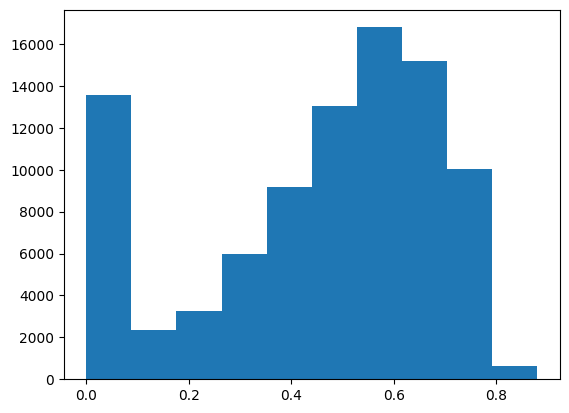

In [52]:
plt.hist(test_pred_total_mean)

In [53]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('CODE_recentgit_lgbmcat_cpu_mac_sunghyun+StandardScaler+addfeatures.csv', index=False)